# Project: Diagnostic reasoning assistant

**Author:** Julia Parnis 
**Date:** February 7, 2026  
**Project:** Data Science Bootcamp - Final Projec

# Re-check 2.4!

C. Unused / confusing things to remove or rename
Remove unused imports

concatenate_datasets is imported but not used.

repeated imports at the bottom (cells 70–73) — delete those cells.

✅ Keep all imports only at the top, once.

Avoid reusing the name antecedents

You use antecedents to mean:

a list of antecedent evidence codes (mapping-level)

later also used in narrative as “antecedents per patient”

✅ Rename mapping-level lists to:

antecedent_codes

symptom_codes

This single change will reduce cognitive load a lot.

## Project Overview

**Goal:** Build an AI-powered diagnostic assistant that provides ranked differential diagnoses through iterative questioning, with enhanced detection of rare and overlooked conditions.

**Key Innovation:** Two-tier ML architecture combined with RAG (Retrieval-Augmented Generation) for transparent clinical reasoning and literature-backed rare disease identification.

**Dataset:** DDXPlus - 1.3M synthetic patient cases, 49 pathologies  
**Source:** [Hugging Face](https://huggingface.co/datasets/aai530-group6/ddxplus)
**Citation:** Fansi Tchango et al. (2022)

**Note:** This is a synthetic dataset (computer-generated from medical knowledge bases) designed for research and education. It provides a robust, privacy-compliant foundation for developing diagnostic AI systems.

# Notebook 1: Data Exploration

**Objective:** Load and explore the DDXPlus dataset to understand structure, quality, and feature distributions.

**Tasks:**
1. Load and inspect dataset structure
2. Fix data type issues
3. Assess data quality (missing values, duplicates)
4. Visualize key patterns (diseases, demographics, symptoms)
5. Analyze evidence and condition mappings
6. Save processed data for modeling


## 1. Setup & Data Loading

In [3]:
# 1.1 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import os
from collections import Counter
from datasets import load_dataset, concatenate_datasets

print("✓ Libraries imported")


c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported


In [4]:
# Creating directories
os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)   
os.makedirs("data/processed", exist_ok=True)


In [5]:
# 1.2 Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Display settings configured")


✓ Display settings configured


In [6]:
# 1.3 Visualization Settings (Academic Style - Colorblind Safe)
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk", font_scale=0.9)

# IBM Design colorblind-safe palette
IBM_COLORS = {
    'blue': '#648FFF',
    'purple': '#785EF0', 
    'magenta': '#DC267F',
    'orange': '#FE6100',
    'yellow': '#FFB000',
    'teal': '#06A39B',
    'gray': '#5F6368'
}

# Figure parameters
FIGSIZE_SINGLE = (10, 6)
FIGSIZE_DOUBLE = (14, 6)
DPI = 300  # High resolution for presentations

print("✓ Visualization settings configured")


✓ Visualization settings configured


In [7]:
# 1.4 Load Dataset from Hugging Face
from datasets import load_dataset

dataset = load_dataset("aai530-group6/ddxplus")

print(f"✓ Dataset loaded from Hugging Face")
print(f"\nSplit breakdown:")
print(f"  Train:      {len(dataset['train']):>8,} examples ({len(dataset['train'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Validation: {len(dataset['validate']):>8,} examples ({len(dataset['validate'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Test:       {len(dataset['test']):>8,} examples ({len(dataset['test'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Total:      {sum([len(dataset[s]) for s in dataset]):>8,} examples")


✓ Dataset loaded from Hugging Face

Split breakdown:
  Train:      1,025,602 examples (79.3%)
  Validation:  132,448 examples (10.2%)
  Test:        134,529 examples (10.4%)
  Total:      1,292,579 examples


In [8]:
type(dataset)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 1025602
    })
    test: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 134529
    })
    validate: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 132448
    })
})


**Observation:** Dataset comes pre-split into train/validation/test sets and appears in datasets.dataset_dict.DatasetDict format.

**Decision:** Convert to pandas format for easier EDA and combine all splits for comprehensive EDA. We'll respect the original splits during modeling.


In [9]:
# ============================================================================
# Section 1.5 - Combine Splits with Split Identifier
# ============================================================================

print("\n" + "="*70)
print("COMBINING DATASET SPLITS")
print("="*70)

# Convert each split to pandas and add split identifier
df_train = dataset['train'].to_pandas()
df_train['split'] = 'train'
print(f"✓ Train set: {len(df_train):,} samples")

df_validate = dataset['validate'].to_pandas()
df_validate['split'] = 'validate'
print(f"✓ Validation set: {len(df_validate):,} samples")

df_test = dataset['test'].to_pandas()
df_test['split'] = 'test'
print(f"✓ Test set: {len(df_test):,} samples")

# Concatenate all splits
df_all = pd.concat([df_train, df_validate, df_test], ignore_index=True)

print(f"\n✓ Combined DataFrame: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")

# Verify split distribution
print("\nSplit distribution:")
print(df_all['split'].value_counts())
print("\nSplit percentages:")
print(df_all['split'].value_counts(normalize=True) * 100)



COMBINING DATASET SPLITS
✓ Train set: 1,025,602 samples
✓ Validation set: 132,448 samples
✓ Test set: 134,529 samples

✓ Combined DataFrame: 1,292,579 rows × 7 columns

Split distribution:
split
train       1025602
test         134529
validate     132448
Name: count, dtype: int64

Split percentages:
split
train       79.345402
test        10.407797
validate    10.246801
Name: proportion, dtype: float64


In [10]:
# 1.6 Load Mapping Files (Evidences and Conditions)
# Load evidence codes (symptoms/findings)
with open('data/release_evidences.json', 'r', encoding='utf-8') as f:
    evidences = json.load(f)

# Load condition codes (diseases)
with open('data/release_conditions.json', 'r', encoding='utf-8') as f:
    conditions = json.load(f)

print(f"✓ Mapping files loaded:")
print(f"  Evidences (symptoms/findings): {len(evidences)} codes; \nType: {type(evidences)}")
print(f"  Conditions (diseases):         {len(conditions)} codes; \nType: {type(conditions)}")


✓ Mapping files loaded:
  Evidences (symptoms/findings): 223 codes; 
Type: <class 'dict'>
  Conditions (diseases):         49 codes; 
Type: <class 'dict'>


In [11]:
# 1.7 Inspect JSON File Structure

print("="*70)
print("EVIDENCE MAPPING STRUCTURE")
print("="*70)

# Show one example evidence
sample_evidence_code = list(evidences.keys())[0]
print(f"\nSample evidence code: {sample_evidence_code}")
print(f"Structure:")
print(json.dumps(evidences[sample_evidence_code], indent=2))

# Check what fields are available
sample_fields = evidences[sample_evidence_code].keys()
print(f"\nAvailable fields in evidence mapping: {list(sample_fields)}")

print("\n" + "="*70)
print("CONDITION MAPPING STRUCTURE")
print("="*70)

# Show one example condition
sample_condition = list(conditions.keys())[0]
print(f"\nSample condition: {sample_condition}")
print(f"Structure (first 500 characters):")
print(json.dumps(conditions[sample_condition], indent=2)[:500] + "...")

# Check what fields are available
sample_fields = conditions[sample_condition].keys()
print(f"\nAvailable fields in condition mapping: {list(sample_fields)}")

print("\n✓ JSON files are Python dictionaries - ready to use for lookups")



EVIDENCE MAPPING STRUCTURE

Sample evidence code: E_91
Structure:
{
  "name": "E_91",
  "code_question": "E_91",
  "question_fr": "Avez-vous objectiv\u00e9 ou ressenti de la fi\u00e8vre?",
  "question_en": "Do you have a fever (either felt or measured with a thermometer)?",
  "is_antecedent": false,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}

Available fields in evidence mapping: ['name', 'code_question', 'question_fr', 'question_en', 'is_antecedent', 'default_value', 'value_meaning', 'possible-values', 'data_type']

CONDITION MAPPING STRUCTURE

Sample condition: Spontaneous pneumothorax
Structure (first 500 characters):
{
  "condition_name": "Spontaneous pneumothorax",
  "cond-name-fr": "Pneumothorax spontan\u00e9",
  "cond-name-eng": "Spontaneous pneumothorax",
  "icd10-id": "J93",
  "symptoms": {
    "E_55": {},
    "E_53": {},
    "E_57": {},
    "E_54": {},
    "E_59": {},
    "E_56": {},
    "E_58": {},
    "E_66": {},
    "E_220": 

## 2. Initial Data Inspection

**Purpose:** Understand data structure and identify/fix type issues before analysis.


In [12]:
# 2.1 Dataset Structure Overview
print("="*70)
print("DATASET STRUCTURE")
print("="*70)

print(f"\nShape: {df_all.shape}")
print(f"Rows: {df_all.shape[0]:,}")
print(f"Columns: {df_all.shape[1]}")

print("\nColumn Names:")
for i, col in enumerate(df_all.columns, 1):
    print(f"  {i}. {col}")

print("\nFirst 3 rows:")
display(df_all.head(3))

print("\nBasic statistics:")
display(df_all.describe())
print(f"Sex: {df_all['SEX'].value_counts().to_dict()}")


DATASET STRUCTURE

Shape: (1292579, 7)
Rows: 1,292,579
Columns: 7

Column Names:
  1. AGE
  2. DIFFERENTIAL_DIAGNOSIS
  3. SEX
  4. PATHOLOGY
  5. EVIDENCES
  6. INITIAL_EVIDENCE
  7. split

First 3 rows:


,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,split
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366], ['URTI', 0.16078097198...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_...",E_91,train
1,21,"[['HIV (initial infection)', 0.5189500564407601], ['Chagas', 0.3217819010436332], ['Scombroid fo...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_@_V_198', 'E_55_@_V_62', 'E_55_@_V_166', 'E_55_@_V...",E_50,train
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumonia', 0.10048134562119852], ['Unstable angina', 0....",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55_@_V_29', 'E_55_@_V_55', 'E_55_@_V_56', 'E_55_@_V_...",E_77,train



Basic statistics:


,AGE
count,1.292579e+06
mean,3.972967e+01
std,2.272213e+01
min,0.000000e+00
25%,2.200000e+01
50%,3.900000e+01
75%,5.600000e+01
max,1.090000e+02


Sex: {'F': 665273, 'M': 627306}


In [13]:
# 2.2 Data Type Investigation
print("="*70)
print("DATA TYPE INSPECTION")
print("="*70)

# Show overview
df_all.info()

# Identify string-encoded lists/dicts
print("\n" + "Checking for string-encoded data structures...")
problem_cols = []

for col in df_all.columns:
    sample = df_all[col].iloc[0]
    if isinstance(sample, str) and (sample.startswith('[') or sample.startswith('{')):
        problem_cols.append(col)
        print(f"  ⚠️  {col}: Currently {type(sample).__name__}, should be {'list' if sample.startswith('[') else 'dict'}")

if not problem_cols:
    print("  ✓ All data types are correct")
else:
    print(f"\n{len(problem_cols)} column(s) need type conversion")


DATA TYPE INSPECTION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292579 entries, 0 to 1292578
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   AGE                     1292579 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  1292579 non-null  object
 2   SEX                     1292579 non-null  object
 3   PATHOLOGY               1292579 non-null  object
 4   EVIDENCES               1292579 non-null  object
 5   INITIAL_EVIDENCE        1292579 non-null  object
 6   split                   1292579 non-null  object
dtypes: int64(1), object(6)
memory usage: 69.0+ MB

Checking for string-encoded data structures...
  ⚠️  DIFFERENTIAL_DIAGNOSIS: Currently str, should be list
  ⚠️  EVIDENCES: Currently str, should be list

2 column(s) need type conversion


### Data Type Issue Discovered

**Problem:** Columns `EVIDENCES` and `DIFFERENTIAL_DIAGNOSIS` are stored as strings instead of Python lists.

**Example:**
- String: `"['E_48', 'E_50', 'E_53']"` (221 characters)
- Should be: `['E_48', 'E_50', 'E_53']` (3 items)

**Impact:** Using `len()` counts characters instead of list items → wrong symptom counts (240 vs 20).

**Fix:** Convert strings to proper Python data structures using `ast.literal_eval()`.


In [14]:
# 2.3 Create List Columns from String Representations
import ast

print("Creating list versions while preserving original string columns...")

#  EVIDENCES and DIFFERENTIAL_DIAGNOSIS: Convert string representation to Python list, Create NEW list columns 
df_all['EVIDENCES_list'] = df_all['EVIDENCES'].apply(ast.literal_eval)
df_all['DIFFERENTIAL_DIAGNOSIS_list'] = df_all['DIFFERENTIAL_DIAGNOSIS'].apply(ast.literal_eval)

# Verification
print("\nVerification:")
patient0 = df_all.iloc[0]
print(f"  EVIDENCES type: {type(patient0['EVIDENCES_list'])}")
print(f"  EVIDENCES sample: {patient0['EVIDENCES_list'][:5]}")
print(f"  EVIDENCES count: {len(patient0['EVIDENCES_list'])} items")
print(f"\n  DIFFERENTIAL_DIAGNOSIS type: {type(patient0['DIFFERENTIAL_DIAGNOSIS_list'])}")
print(f"  DIFFERENTIAL_DIAGNOSIS sample: {patient0['DIFFERENTIAL_DIAGNOSIS_list'][:2]}")


Creating list versions while preserving original string columns...

Verification:
  EVIDENCES type: <class 'list'>
  EVIDENCES sample: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183']
  EVIDENCES count: 19 items

  DIFFERENTIAL_DIAGNOSIS type: <class 'list'>
  DIFFERENTIAL_DIAGNOSIS sample: [['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366]]


In [66]:
def to_base(code: str) -> str:
    return code.split("_@_")[0]  # safe for both base and value-coded

In [ ]:
# 2.4 Create Derived Columns
print("Creating derived columns...")

# Count number of evidences (symptoms/findings) per patient
df_all["num_evidences_raw"] = df_all["EVIDENCES_list"].apply(len)
# Taking into the consideration evidences repetition in multichoice evidences
df_all["num_evidences_base"] = df_all["EVIDENCES_list"].apply(lambda lst: len({to_base(c) for c in lst}))

print("  num_evidences: ")
display(df_all['num_evidences_base'].describe())


Creating derived columns...
  num_evidences: 


count    1.278666e+06
mean     1.547423e+01
std      5.483789e+00
min      2.000000e+00
25%      1.200000e+01
50%      1.500000e+01
75%      1.900000e+01
max      3.900000e+01
Name: num_evidences_base, dtype: float64

In [15]:
# 2.4 Create Derived Columns
print("Creating derived columns...")

# Count number of evidences (symptoms/findings) per patient
df_all['num_evidences'] = df_all['EVIDENCES_list'].apply(len)

print(f"\n✓ Derived columns created:")
print(f"  num_evidences:           \n{df_all['num_evidences'].describe()}")

Creating derived columns...

✓ Derived columns created:
  num_evidences:           
count    1.292579e+06
mean     1.977426e+01
std      8.012032e+00
min      2.000000e+00
25%      1.500000e+01
50%      2.000000e+01
75%      2.500000e+01
max      4.700000e+01
Name: num_evidences, dtype: float64


### 2.5 Evidence Mapping Validation

**Purpose:** Verify completeness and consistency of the evidence (symptoms/findings) mapping file.


In [16]:
# Code Cell
print("="*70)
print("EVIDENCE MAPPING VALIDATION")
print("="*70)

# Expected count
print(f"\n✓ Total evidence codes loaded: {len(evidences)}")

# Check for missing or null fields
print("\nChecking field completeness...")
required_fields = ['name', 'code_question', 'question_en', 'data_type', 'is_antecedent']
missing_data = []

for code, details in evidences.items():
    for field in required_fields:
        if field not in details or details[field] is None or details[field] == '':
            missing_data.append({
                'code': code,
                'field': field,
                'value': details.get(field, 'MISSING')
            })

if missing_data:
    print(f"⚠️  Found {len(missing_data)} missing/null fields:")
    for item in missing_data[:5]:  # Show first 5
        print(f"   {item['code']}: {item['field']} = {item['value']}")
else:
    print("✓ All required fields are populated")

# Check data types
print(f"\nData type distribution:")
data_types = {}
for code, details in evidences.items():
    dtype = details.get('data_type', 'UNKNOWN')
    data_types[dtype] = data_types.get(dtype, 0) + 1

for dtype, count in sorted(data_types.items()):
    print(f"   {dtype}: {count} codes ({count/len(evidences)*100:.1f}%)")


EVIDENCE MAPPING VALIDATION

✓ Total evidence codes loaded: 223

Checking field completeness...
✓ All required fields are populated

Data type distribution:
   B: 208 codes (93.3%)
   C: 10 codes (4.5%)
   M: 5 codes (2.2%)


In [17]:
# Antedecent analysis
print("\n" + "="*70)
print("ANTECEDENT ANALYSIS")
print("="*70)

# Count antecedents vs symptoms
antecedents = [code for code, details in evidences.items() 
               if details.get('is_antecedent') == True]
symptoms = [code for code, details in evidences.items() 
            if details.get('is_antecedent') == False]

print(f"\nEvidence classification:")
print(f"   Symptoms/Findings: {len(symptoms)} ({len(symptoms)/len(evidences)*100:.1f}%)")
print(f"   Antecedents (medical history): {len(antecedents)} ({len(antecedents)/len(evidences)*100:.1f}%)")

# Show examples
print(f"\nExample antecedents (first 5):")
for code in antecedents[:5]:
    print(f"   {code}: {evidences[code]['question_en'][:60]}...")



ANTECEDENT ANALYSIS

Evidence classification:
   Symptoms/Findings: 110 (49.3%)
   Antecedents (medical history): 113 (50.7%)

Example antecedents (first 5):
   E_16: Do you feel anxious?...
   E_102: Are you consulting because you have high blood pressure?...
   E_196: Have you had surgery within the last month?...
   E_78: Do you drink alcohol excessively or do you have an addiction...
   E_146: Are you taking any new oral anticoagulants ((NOACs)?...


In [18]:
# Check for inconsistencies in evidences codes (e.g., should be 'E_53', 'E_54_@_V_161')
print("\n" + "="*70)
print("EVIDENCE CODE FORMAT VALIDATION")
print("="*70)

# Check if all codes follow expected pattern (E_number or E+number)
import re

# Updated pattern to handle underscore
valid_pattern = re.compile(r'^E_?\d+$')  # Matches E123 or E_123
invalid_codes = []

for code in evidences.keys():
    if not valid_pattern.match(code):
        invalid_codes.append(code)

if invalid_codes:
    print(f"⚠️  Found {len(invalid_codes)} codes with unexpected format:")
    print(f"   {invalid_codes[:10]}")  # Show first 10
else:
    print(f"✓ All {len(evidences)} codes follow expected format (E_number)")

# Check for sequential numbering gaps
# Handle both E_123 and E123 formats
code_numbers = []
for code in evidences.keys():
    # Remove 'E' and any underscores, then convert to int
    num_str = code.replace('E', '').replace('_', '')
    try:
        code_numbers.append(int(num_str))
    except ValueError:
        print(f"⚠️  Could not parse number from code: {code}")

code_numbers = sorted(code_numbers)

if code_numbers:
    print(f"\nCode range: E_{code_numbers[0]} to E_{code_numbers[-1]}")
    print(f"Expected codes (if sequential): {code_numbers[-1] - code_numbers[0] + 1}")
    print(f"Actual codes: {len(code_numbers)}")
    
    missing_codes = code_numbers[-1] - code_numbers[0] + 1 - len(code_numbers)
    if missing_codes > 0:
        print(f"⚠️  {missing_codes} code(s) missing in sequence")
        
        # Find which codes are missing
        full_range = set(range(code_numbers[0], code_numbers[-1] + 1))
        actual_codes = set(code_numbers)
        missing = sorted(full_range - actual_codes)
        
        if len(missing) <= 10:
            print(f"   Missing: {['E_' + str(n) for n in missing]}")
        else:
            print(f"   Missing: {['E_' + str(n) for n in missing[:10]]} ... and {len(missing)-10} more")
    else:
        print("✓ No gaps in numbering sequence")



EVIDENCE CODE FORMAT VALIDATION
✓ All 223 codes follow expected format (E_number)

Code range: E_0 to E_227
Expected codes (if sequential): 228
Actual codes: 223
⚠️  5 code(s) missing in sequence
   Missing: ['E_36', 'E_68', 'E_85', 'E_117', 'E_122']


In [19]:
# ============================================================================
# Check that 5 missing evidences' codes are not used in data
# ============================================================================

# Step 1: Define helper function for extracting base codes


def to_base_code(code: str) -> str:
    """
    Extract base evidence code from full code string.
    
    DDXPlus evidence codes come in several formats:
    - Binary: "E_10" or "E_10_V_1" (with value indicator)
    - Categorical: "E_130_@_V_86" (with chosen value)
    
    We want just the base code (e.g., "E_130", "E_10")
    
    Args:
        code: Evidence code from patient data
        
    Returns:
        Base evidence code without value indicators
        
    Examples:
        >>> to_base_code("E_130_@_V_86")
        'E_130'
        >>> to_base_code("E_5_V_1")
        'E_5'
        >>> to_base_code("E_10")
        'E_10'
    """
    # Check for categorical format first (most specific pattern)
    if "_@_" in code:
        return code.split("_@_")[0]
    
    # Then check for value indicator format
    elif "V" in code:
        # Split at V and remove any trailing underscore
        base = code.split("V")[0]
        return base.rstrip("_")
    
    # Otherwise, code is already in base form
    else:
        return code


# ============================================================================
# Check that 5 missing evidences' codes are not used in data
# ============================================================================

print("="*70)
print("CHECKING IF MISSING EVIDENCE CODES ARE USED IN DATA")
print("="*70)

missing_from_json = ['E_36', 'E_68', 'E_85', 'E_117', 'E_122']

print(f"\nCodes missing from evidences.json: {missing_from_json}")
print(f"Total missing: {len(missing_from_json)}")

print("\n" + "-"*70)
print("Collecting all evidence codes from patient data...")
print("-"*70)

# Collect all unique base codes from patient data
all_codes_in_data = set()

for evidence_list in df_all['EVIDENCES_list']:
    for code in evidence_list:
        base_code = to_base_code(code)
        all_codes_in_data.add(base_code)

all_codes_in_data = sorted(list(all_codes_in_data))

print(f"✓ Collected {len(all_codes_in_data)} unique evidence codes from data")

# Show sample of extracted codes for verification
print("\nSample of extracted base codes:")
for code in all_codes_in_data[:10]:
    print(f"   {code}")

print("\n" + "-"*70)
print("Checking if missing codes are used by patients...")
print("-"*70)

problematic_codes = []

for code in missing_from_json:
    if code in all_codes_in_data:
        problematic_codes.append(code)
        print(f"⚠️  {code} - FOUND IN DATA (this is a problem!)")
    else:
        print(f"✓  {code} - Not used in data (safe to ignore)")

if problematic_codes:
    print("\n" + "="*70)
    print("⚠️  PROBLEM DETECTED - Counting impact...")
    print("="*70)
    
    # For each problematic code, count how many patients use it
    for code in problematic_codes:       
        count = 0
        affected_patients = []
        
        for idx, evidence_list in enumerate(df_all['EVIDENCES_list']):
            # Check if any evidence in list has this base code
            patient_has_code = any(to_base_code(ev) == code for ev in evidence_list)
            
            if patient_has_code:
                count += 1
                if len(affected_patients) < 5:
                    affected_patients.append(idx)
        
        print(f"\n{code}:")
        print(f"   Used by {count} patients ({count/len(df_all)*100:.2f}% of data)")
        print(f"   Example patient indices: {affected_patients[:5]}")
    
    print("\n⚠️  ACTION REQUIRED: These codes need descriptions from domain expert")
    
else:
    print("\n" + "="*70)
    print("✓ ALL CLEAR - Missing codes are not used in data")
    print("="*70)
    print("\nConclusion: The 5 missing codes are just gaps in numbering.")
    print("They don't affect our analysis since no patients have them.")


# ============================================================================
# Check whether there are codes in data but not in evidences.json
# ============================================================================

print("\n" + "="*70)
print("REVERSE CHECK: Codes in data but missing from evidences.json")
print("="*70)

codes_in_json = set(evidences.keys())

# Find codes that are in data but not in JSON (orphaned codes)
orphaned_codes = [code for code in all_codes_in_data if code not in codes_in_json]

if orphaned_codes:
    print(f"\n⚠️  Found {len(orphaned_codes)} codes in data but not in evidences.json:")
    for code in sorted(orphaned_codes)[:10]:  # Show first 10
        print(f"   {code}")
    if len(orphaned_codes) > 10:
        print(f"   ... and {len(orphaned_codes) - 10} more")
else:
    print("\n✓ All codes used in data exist in evidences.json")
    print("✓ Data integrity confirmed!")


CHECKING IF MISSING EVIDENCE CODES ARE USED IN DATA

Codes missing from evidences.json: ['E_36', 'E_68', 'E_85', 'E_117', 'E_122']
Total missing: 5

----------------------------------------------------------------------
----------------------------------------------------------------------
✓ Collected 223 unique evidence codes from data

Sample of extracted base codes:
   E_0
   E_1
   E_10
   E_100
   E_101
   E_102
   E_103
   E_104
   E_105
   E_106

----------------------------------------------------------------------
Checking if missing codes are used by patients...
----------------------------------------------------------------------
✓  E_36 - Not used in data (safe to ignore)
✓  E_68 - Not used in data (safe to ignore)
✓  E_85 - Not used in data (safe to ignore)
✓  E_117 - Not used in data (safe to ignore)
✓  E_122 - Not used in data (safe to ignore)

✓ ALL CLEAR - Missing codes are not used in data

Conclusion: The 5 missing codes are just gaps in numbering.
They don't affect

## 3. Data Quality Assessment

**Purpose:** Check for missing values, duplicates, and data integrity issues.


In [20]:
# 3.1 Missing Values
print("="*70)
print("MISSING VALUES CHECK")
print("="*70)

missing = df_all.isnull().sum()
print(missing)

if missing.sum() == 0:
    print("\n✓ No missing values found - dataset is complete")
else:
    print(f"\n⚠️  {missing.sum()} missing values found")


MISSING VALUES CHECK
AGE                            0
DIFFERENTIAL_DIAGNOSIS         0
SEX                            0
PATHOLOGY                      0
EVIDENCES                      0
INITIAL_EVIDENCE               0
split                          0
EVIDENCES_list                 0
DIFFERENTIAL_DIAGNOSIS_list    0
num_evidences                  0
dtype: int64

✓ No missing values found - dataset is complete


In [21]:
# 3.2 Duplicate Rows
print("="*70)
print("DUPLICATE CHECK")
print("="*70)

original_cols = ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
duplicates = df_all.duplicated(subset=original_cols).sum()
print(f"Duplicate rows (all columns): {duplicates}")

if duplicates == 0:
    print("✓ No duplicate rows found - all 1,292,579 cases are unique")
else:
    print(f"⚠️  {duplicates} duplicate rows detected")


DUPLICATE CHECK
Duplicate rows (all columns): 13913
⚠️  13913 duplicate rows detected


In [22]:
# 3.2.1 Investigate the Duplicates
print("\n" + "="*70)
print("DUPLICATE INVESTIGATION")
print("="*70)

# Get the duplicate rows
duplicate_mask = df_all.duplicated(subset=original_cols, keep=False)
duplicate_rows = df_all[duplicate_mask]

print(f"Total duplicate rows: {len(duplicate_rows):,}")
print(f"Percentage of dataset: {len(duplicate_rows)/len(df_all)*100:.2f}%")

# How many unique cases are duplicated?
unique_duplicate_cases = df_all[duplicate_mask].drop_duplicates(subset=original_cols)
print(f"Number of unique patterns that are duplicated: {len(unique_duplicate_cases):,}")

# Show examples
print("\nExample of duplicate rows:")
print("-"*70)
# Get one duplicate set
first_duplicate = df_all[duplicate_mask].iloc[0]
same_rows = df_all[
    (df_all['AGE'] == first_duplicate['AGE']) &
    (df_all['SEX'] == first_duplicate['SEX']) &
    (df_all['PATHOLOGY'] == first_duplicate['PATHOLOGY']) &
    (df_all['EVIDENCES'] == first_duplicate['EVIDENCES']) &
    (df_all['DIFFERENTIAL_DIAGNOSIS'] == first_duplicate['DIFFERENTIAL_DIAGNOSIS']) &
    (df_all['INITIAL_EVIDENCE'] == first_duplicate['INITIAL_EVIDENCE'])
]

print(f"\nThis pattern appears {len(same_rows)} times:")
print(f"  Age: {first_duplicate['AGE']}")
print(f"  Sex: {first_duplicate['SEX']}")
print(f"  Disease: {first_duplicate['PATHOLOGY']}")
print(f"  Initial evidence: {first_duplicate['INITIAL_EVIDENCE']}")
print(f"  Number of symptoms: {len(first_duplicate['EVIDENCES_list'])}")



DUPLICATE INVESTIGATION
Total duplicate rows: 26,227
Percentage of dataset: 2.03%
Number of unique patterns that are duplicated: 12,314

Example of duplicate rows:
----------------------------------------------------------------------

This pattern appears 2 times:
  Age: 49
  Sex: F
  Disease: Allergic sinusitis
  Initial evidence: E_169
  Number of symptoms: 10


### Analysis & Decision on Duplicates

**Findings:**
- 26,227 total rows involved in duplicates (2.03% of dataset)
- 12,314 unique patterns that appear multiple times
- 13,913 duplicate rows (extra copies) if keeping first occurrence
- Most patterns appear exactly 2 times

**Solution: Remove duplicates BUT preserve frequency information**

We'll create a `frequency` column that counts how many times each pattern appears. This approach:
- ✅ Removes redundant data (cleaner training)
- ✅ Preserves information about pattern frequency
- ✅ Enables sample weighting in model training

In [23]:
# Analyze duplication patterns
duplicate_mask = df_all.duplicated(subset=original_cols, keep=False)
duplicate_counts = df_all[duplicate_mask].groupby(original_cols, dropna=False).size()

print("Duplication frequency distribution:")
print(f"  Patterns appearing 2 times: {(duplicate_counts == 2).sum():,}")
print(f"  Patterns appearing 3 times: {(duplicate_counts == 3).sum():,}")
print(f"  Patterns appearing 4+ times: {(duplicate_counts >= 4).sum():,}")
print(f"  Maximum copies: {duplicate_counts.max()}")


Duplication frequency distribution:
  Patterns appearing 2 times: 10,784
  Patterns appearing 3 times: 1,461
  Patterns appearing 4+ times: 69
  Maximum copies: 4


In [24]:
# 3.2.2 Count Duplicates Before Removal
print("="*70)
print("COUNTING DUPLICATE FREQUENCIES")
print("="*70)

# Count how many times each pattern appears
df_all['frequency'] = df_all.groupby(original_cols, dropna=False)[original_cols[0]].transform('count')

# Show distribution
print("Frequency distribution:")
print(df_all['frequency'].value_counts().sort_index())

print(f"\nRows appearing once:  {(df_all['frequency'] == 1).sum():,} ({(df_all['frequency'] == 1).sum()/len(df_all)*100:.1f}%)")
print(f"Rows appearing 2+ times: {(df_all['frequency'] >= 2).sum():,} ({(df_all['frequency'] >= 2).sum()/len(df_all)*100:.1f}%)")
print(f"Maximum frequency: {df_all['frequency'].max()}")

print("\n✓ Frequency column created")


COUNTING DUPLICATE FREQUENCIES
Frequency distribution:
frequency
1    1266352
2      21568
3       4383
4        276
Name: count, dtype: int64

Rows appearing once:  1,266,352 (98.0%)
Rows appearing 2+ times: 26,227 (2.0%)
Maximum frequency: 4

✓ Frequency column created


In [25]:
# 3.2.3 Analyse the data leakage due to duplicated cases (same cases appear across different splits)
import ast
import numpy as np
# Step 1. Parse EVIDENCES into lists + create a stable "sorted tuple"
def prepare_for_leakage_check(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # EVIDENCES is a string representation of a Python list
    df["EVIDENCES_list"] = df["EVIDENCES"].apply(ast.literal_eval)

    # Sort so order doesn't matter; convert to tuple so it's hashable
    df["EVIDENCES_sorted"] = df["EVIDENCES_list"].apply(lambda lst: tuple(sorted(lst)))

    # Step 2. Create a hash (fingerprint) from the features you will use
    key_cols = ["AGE", "SEX", "INITIAL_EVIDENCE", "EVIDENCES_sorted"]
    df["case_hash"] = pd.util.hash_pandas_object(df[key_cols], index=False).astype("uint64")

    return df

df_leakage = prepare_for_leakage_check(df_all)


# Step 3. Compare overlaps (leakage)
train_hash = df_leakage[df_leakage['split'] == 'train']['case_hash'].unique()
val_hash = df_leakage[df_leakage['split'] == 'validate']['case_hash'].unique()
test_hash = df_leakage[df_leakage['split'] == 'test']['case_hash'].unique()


# intersections
train_val_overlap  = np.intersect1d(train_hash, val_hash)
train_test_overlap = np.intersect1d(train_hash, test_hash)
val_test_overlap   = np.intersect1d(val_hash, test_hash)

print("Unique cases per split:")
print("  train:", len(train_hash))
print("  val:  ", len(val_hash))
print("  test: ", len(test_hash))

print("\nOverlaps (should ideally be 0):")
print("  train ∩ val: ", len(train_val_overlap))
print("  train ∩ test:", len(train_test_overlap))
print("  val   ∩ test:", len(val_test_overlap))

# Show a few leaking examples if any
if len(train_test_overlap) > 0:
    leaking = df_leakage[df_leakage['case_hash'].isin(train_test_overlap)].head(5)
    display(leaking[['split', "AGE","SEX","INITIAL_EVIDENCE","PATHOLOGY","num_evidences"]])

   # Detailed evidence comparison for first case
    print("\n" + "="*80)
    print("DETAILED VIEW: First Leaking Case")
    print("="*80)
    
    first_hash = leaking.iloc[0]['case_hash']
    same_cases = df_leakage[df_leakage['case_hash'] == first_hash]
    
    for idx, row in same_cases.iterrows():
        print(f"\nSplit: {row['split']}")
        print(f"  Patient: Age {row['AGE']}, {row['SEX']}, Pathology: {row['PATHOLOGY']}")
        print(f"  Number of evidences: {row['num_evidences']}")
        print(f"  Evidence list (first 10): {row['EVIDENCES_list'][:10]}")
        if len(row['EVIDENCES_list']) > 10:
            print(f"    ... and {len(row['EVIDENCES_list']) - 10} more")
    
    print("\n✓ These are identical cases appearing in multiple splits!")

Unique cases per split:
  train: 1012347
  val:   132373
  test:  134428

Overlaps (should ideally be 0):
  train ∩ val:  1788
  train ∩ test: 1965
  val   ∩ test: 172


,split,AGE,SEX,INITIAL_EVIDENCE,PATHOLOGY,num_evidences
595,train,49,M,E_66,Bronchospasm / acute asthma exacerbation,11
776,train,37,M,E_194,Larygospasm,7
1435,train,63,M,E_194,Larygospasm,5
1565,train,38,F,E_194,Larygospasm,4
1712,train,13,M,E_192,Acute dystonic reactions,9



DETAILED VIEW: First Leaking Case

Split: train
  Patient: Age 49, M, Pathology: Bronchospasm / acute asthma exacerbation
  Number of evidences: 11
  Evidence list (first 10): ['E_46', 'E_66', 'E_87', 'E_101', 'E_116', 'E_119', 'E_124', 'E_204_@_V_10', 'E_214', 'E_222']
    ... and 1 more

Split: test
  Patient: Age 49, M, Pathology: Bronchospasm / acute asthma exacerbation
  Number of evidences: 11
  Evidence list (first 10): ['E_46', 'E_66', 'E_87', 'E_101', 'E_116', 'E_119', 'E_124', 'E_204_@_V_10', 'E_214', 'E_222']
    ... and 1 more

✓ These are identical cases appearing in multiple splits!


In [26]:
# 3.2.3 Remove Duplicates (Keep Frequency Info)
print("\n" + "="*70)
print("REMOVING DUPLICATES (PRESERVING FREQUENCY)")
print("="*70)

original_count = len(df_all)
# original_cols = ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
df_all_original = df_all.copy()

# Remove duplicates but keep the frequency column
df_all = df_all.drop_duplicates(subset=original_cols, keep='first').reset_index(drop=True)

removed_count = original_count - len(df_all)

print(f"Original rows:        {original_count:,}")
print(f"Rows removed:         {removed_count:,}")
print(f"Unique rows:          {len(df_all):,}")

print(f"\n✓ Duplicates removed")
print(f"✓ 'frequency' column preserved for sample weighting")

# Verify
print(f"\nFrequency column summary:")
print(f"  Patterns that were unique: {(df_all['frequency'] == 1).sum():,}")
print(f"  Patterns that were duplicated: {(df_all['frequency'] >= 2).sum():,}")
print(f"  Total weighted samples: {df_all['frequency'].sum():,} (original dataset size)")



REMOVING DUPLICATES (PRESERVING FREQUENCY)
Original rows:        1,292,579
Rows removed:         13,913
Unique rows:          1,278,666

✓ Duplicates removed
✓ 'frequency' column preserved for sample weighting

Frequency column summary:
  Patterns that were unique: 1,266,352
  Patterns that were duplicated: 12,314
  Total weighted samples: 1,292,579 (original dataset size)


In [27]:
# 3.3 Save Cleaned Dataset
print("="*70)
print("SAVING DATASET BEFORE AND AFTER CLEANING")
print("="*70)

import os

# Create directory
os.makedirs('data/processed', exist_ok=True)

# Save data before and after cleaning
df_all.to_pickle('data/processed/ddxplus_all.pkl')
df_all_original.to_pickle('data/processed/ddxplus_original.pkl')

# Get file info
file_size_mb = os.path.getsize('data/processed/ddxplus_all.pkl') / (1024 * 1024)

print(f"✓ Before deduplication: data/processed/ddxplus_all_original.pkl")
print(f"✓ After deduplication: data/processed/ddxplus_all.pkl")
print(f"  Rows: {len(df_all):,}")
print(f"  Columns: {len(df_all.columns)}")
print(f"  Size: {file_size_mb:.1f} MB")
print(f"\n✓ Ready for exploratory analysis (Section 4)")


SAVING DATASET BEFORE AND AFTER CLEANING
✓ Before deduplication: data/processed/ddxplus_all_original.pkl
✓ After deduplication: data/processed/ddxplus_all.pkl
  Rows: 1,278,666
  Columns: 11
  Size: 1128.6 MB

✓ Ready for exploratory analysis (Section 4)


## 4. Exploratory Data Analysis

**Purpose:** Visualize key patterns in disease distribution, demographics, and symptom complexity.


In [28]:
# 4.1 Disease Distribution Analysis
print("="*70)
print("DISEASE (PATHOLOGY) DISTRIBUTION")
print("="*70)

# Count cases per disease
disease_counts = df_all['PATHOLOGY'].value_counts()

print(f"\nTotal unique diseases: {len(disease_counts)}")
print(f"\nTop 10 most common diseases:")
print(disease_counts.head(10))
print(f"\nBottom 10 least common diseases:")
print(disease_counts.tail(10))

# Calculate class imbalance ratio
imbalance_ratio = disease_counts.iloc[0] / disease_counts.iloc[14]  # Top vs 15th
print(f"\nClass imbalance (top vs 15th): {imbalance_ratio:.1f}:1")


DISEASE (PATHOLOGY) DISTRIBUTION

Total unique diseases: 49

Top 10 most common diseases:
PATHOLOGY
URTI                       81767
Viral pharyngitis          78220
Anemia                     64410
HIV (initial infection)    36784
Anaphylaxis                35271
Localized edema            35253
Pulmonary embolism         34872
Influenza                  33956
Bronchitis                 33537
GERD                       32948
Name: count, dtype: int64

Bottom 10 least common diseases:
PATHOLOGY
SLE                         15010
Myocarditis                 14098
Spontaneous pneumothorax    12910
Chagas                      11453
Larygospasm                  7605
Spontaneous rib fracture     7272
Whooping cough               6082
Croup                        3315
Ebola                         908
Bronchiolitis                 322
Name: count, dtype: int64

Class imbalance (top vs 15th): 2.7:1


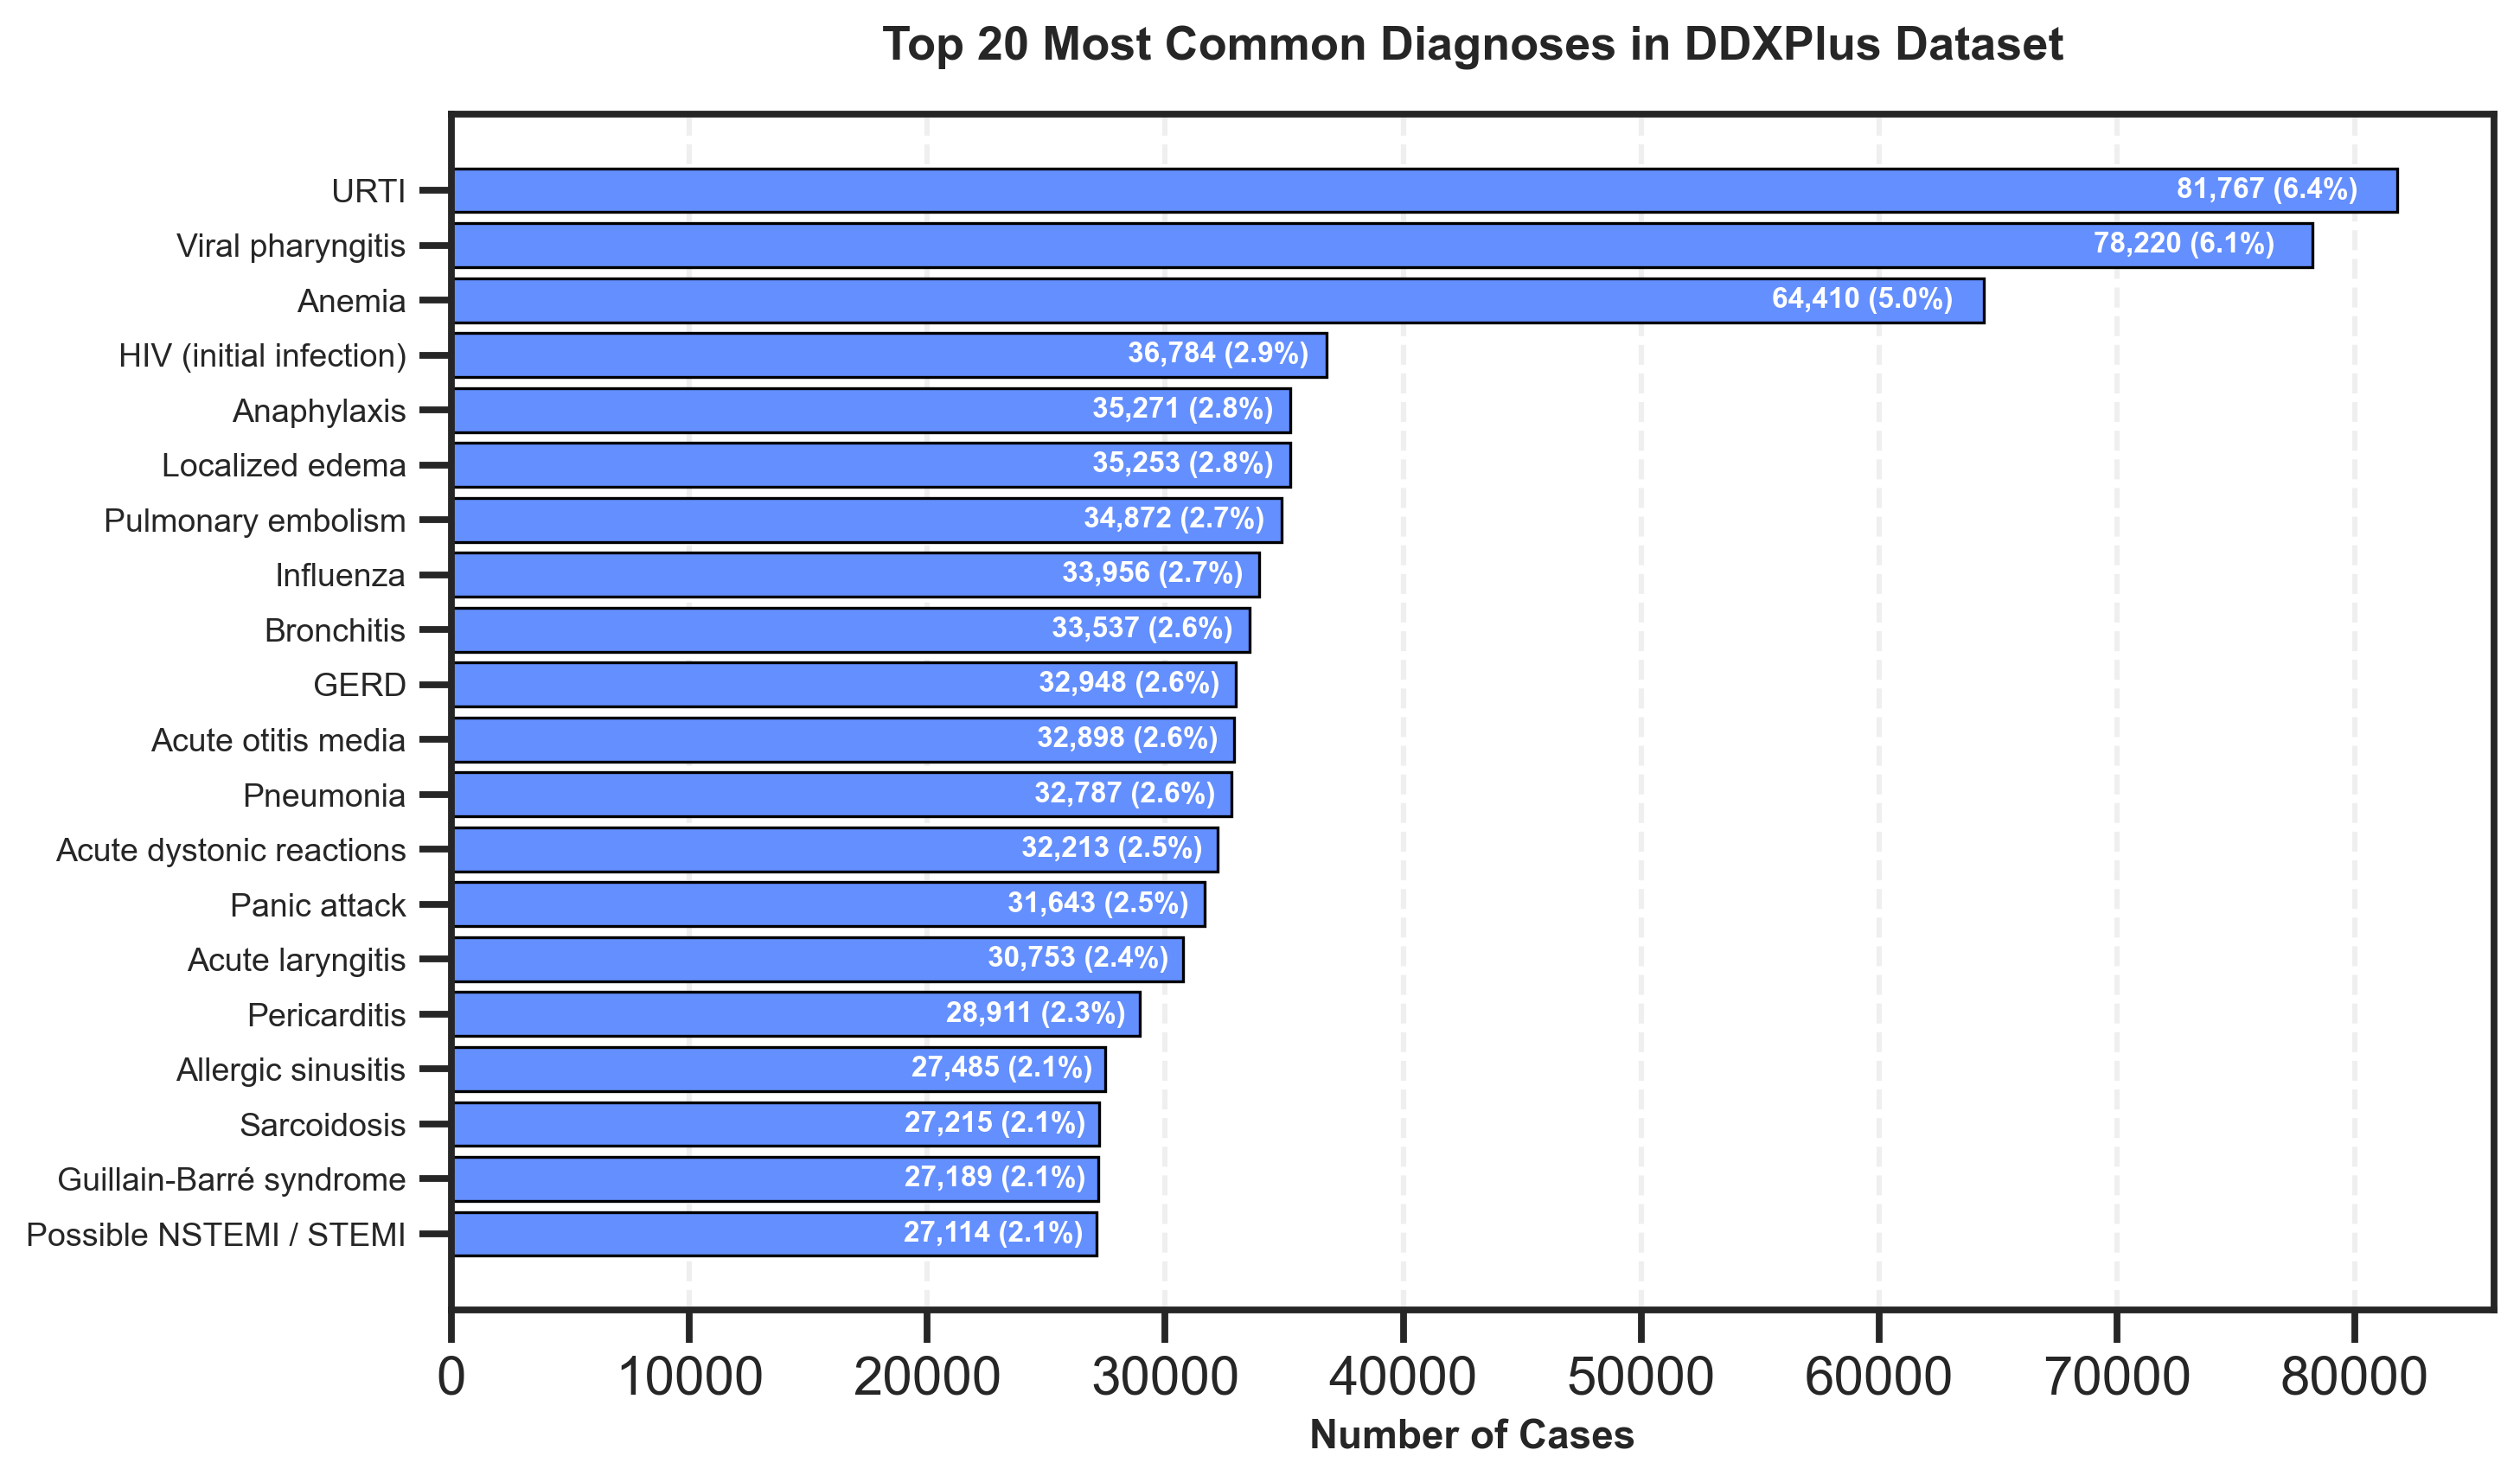

✓ Figure 1 saved: figures/01_disease_distribution.png


In [29]:
# Figure 1: Top 20 Diseases by Frequency
fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE, dpi=DPI)

top_20 = disease_counts.head(20)
total_cases = len(df_all)

bars = ax.barh(range(len(top_20)), top_20.values, color=IBM_COLORS['blue'], edgecolor='black', linewidth=0.8)

# Formatting
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index, fontsize=9)
ax.set_xlabel('Number of Cases', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Most Common Diagnoses in DDXPlus Dataset', 
             fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()

# Add value labels INSIDE bars (right-aligned, white text)
for i, (idx, val) in enumerate(top_20.items()):
    percentage = (val / total_cases) * 100
    label = f'{val:,} ({percentage:.1f}%)'
    
    # Place text inside the bar, 98% from the left edge
    ax.text(val * 0.98, i, label, va='center', ha='right', 
            fontsize=8, color='white', fontweight='bold')

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('figures/01_disease_distribution.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: figures/01_disease_distribution.png")


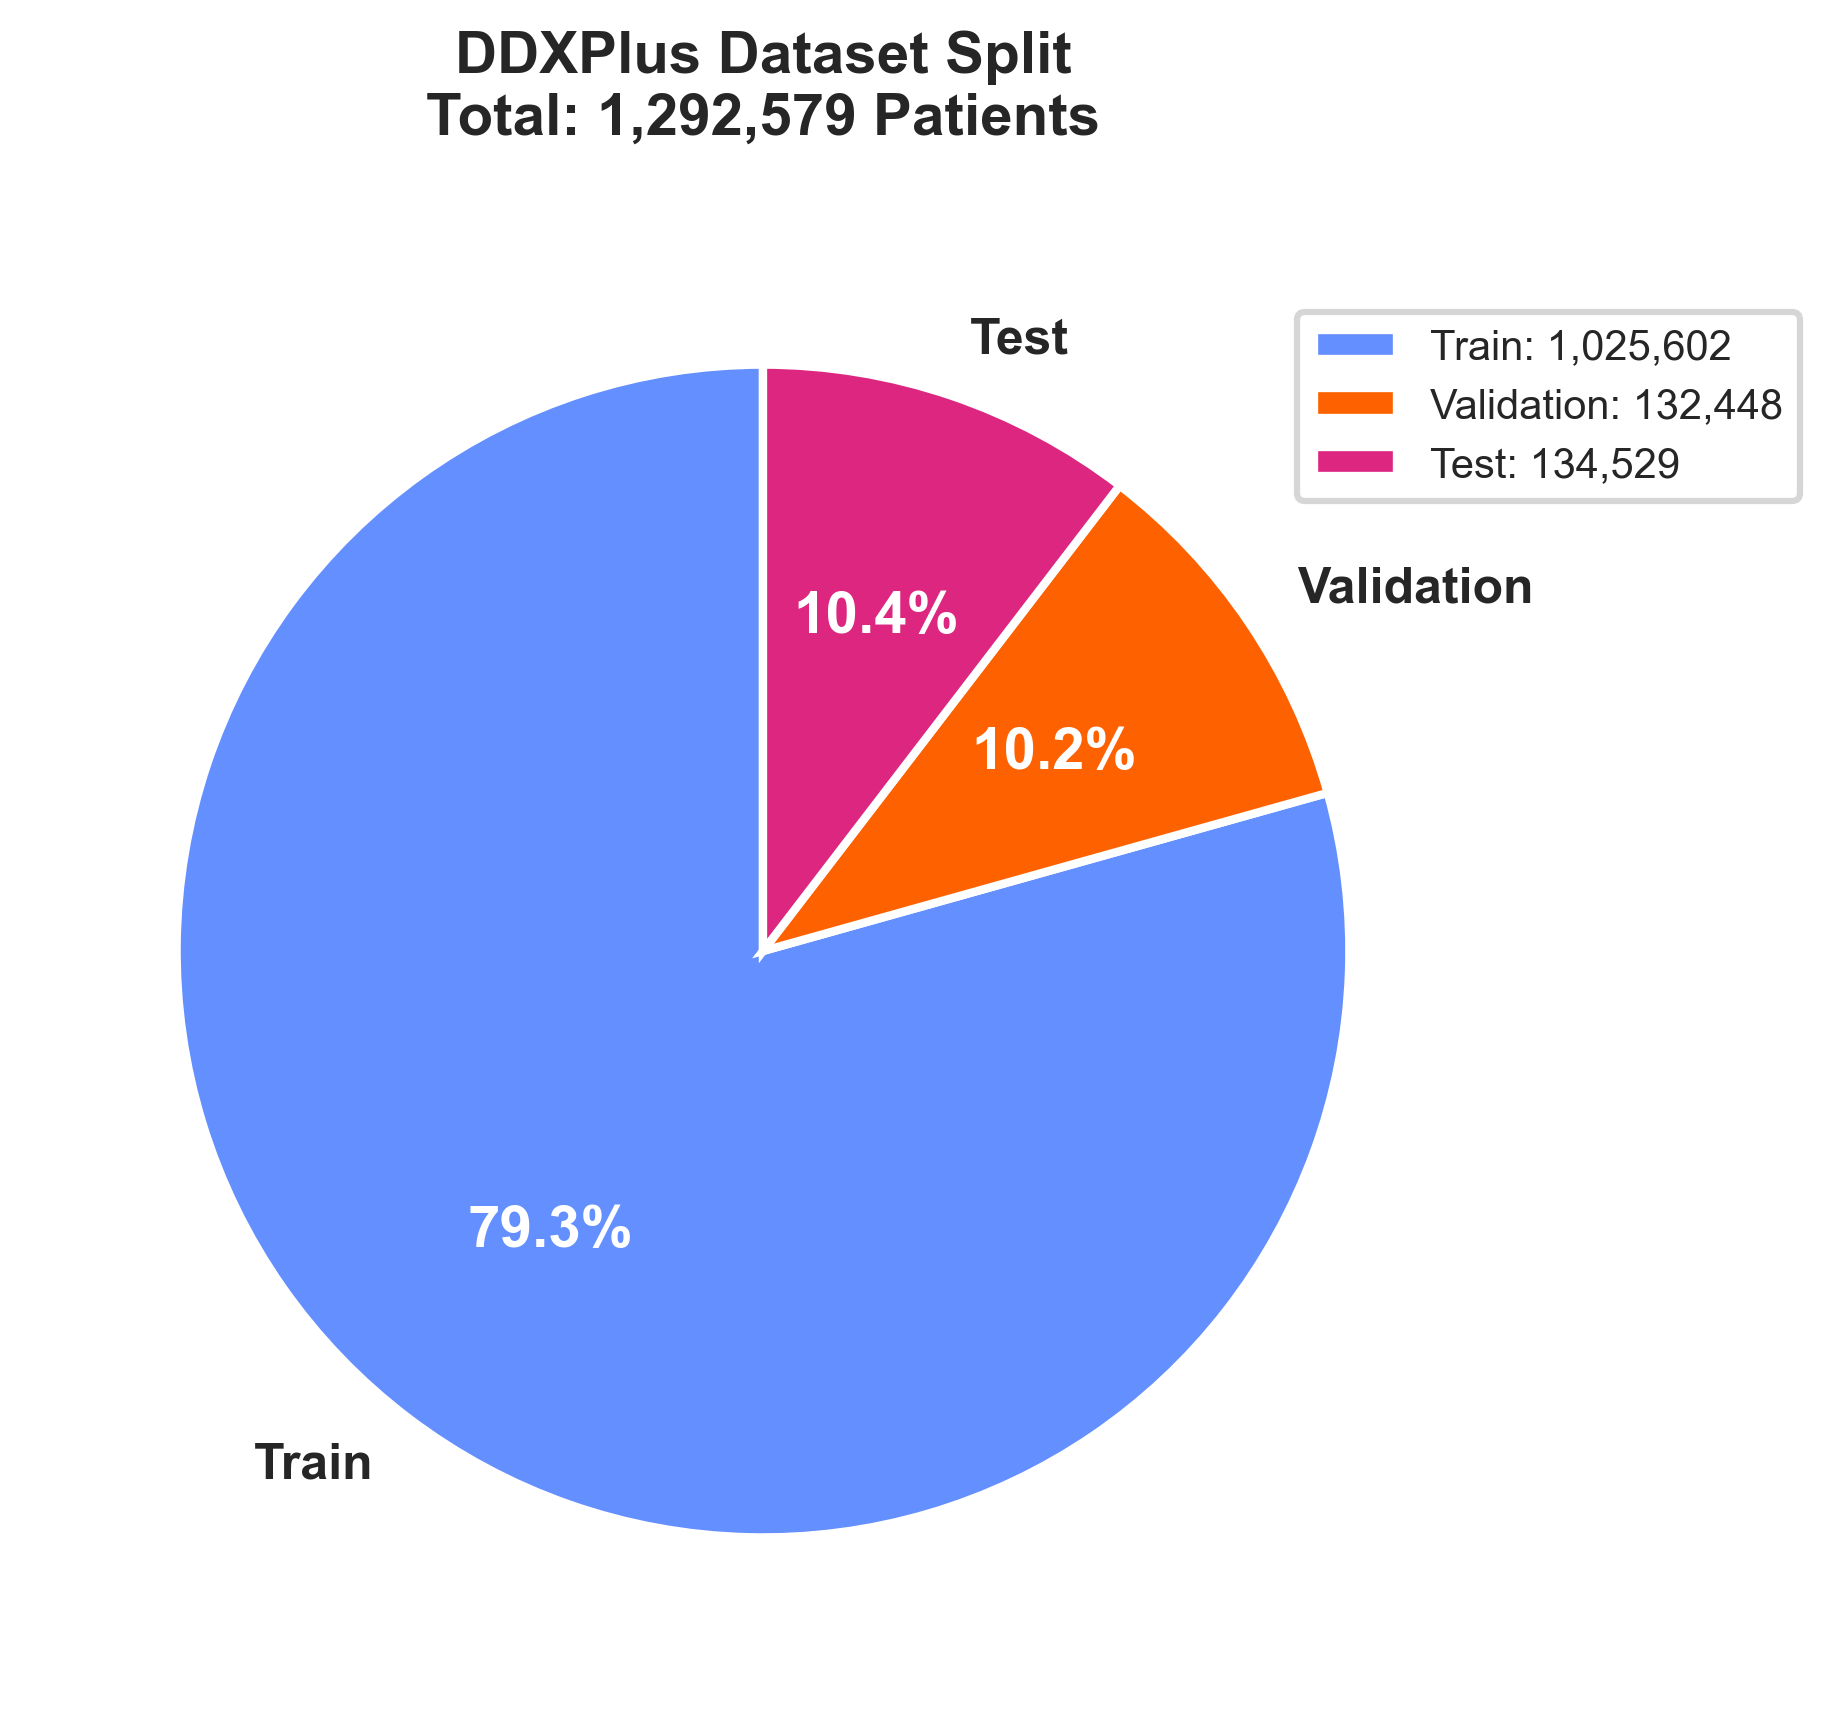

Split proportions:
  Train: 1,025,602 (79.3%)
  Validation: 132,448 (10.2%)
  Test: 134,529 (10.4%)


In [30]:
# Dataset split visualization
fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE, dpi=DPI)

# Data
splits = ['Train', 'Validation', 'Test']
sizes = [len(dataset['train']), len(dataset['validate']), len(dataset['test'])]
percentages = [s/sum(sizes)*100 for s in sizes]
colors_split = [IBM_COLORS['blue'], IBM_COLORS['orange'], IBM_COLORS['magenta']]


# Pie chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=splits,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_split,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Make percentage text white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Title
ax.set_title('DDXPlus Dataset Split\nTotal: 1,292,579 Patients', 
             fontsize=14, fontweight='bold', pad=20)

# Add legend with actual counts
legend_labels = [f'{split}: {size:,}' for split, size in zip(splits, sizes)]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 0.95), 
          frameon=True, fontsize=10)

plt.tight_layout()
plt.savefig('figures/02_dataset_split.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Split proportions:")
for split, size, pct in zip(splits, sizes, percentages):
    print(f"  {split}: {size:,} ({pct:.1f}%)")

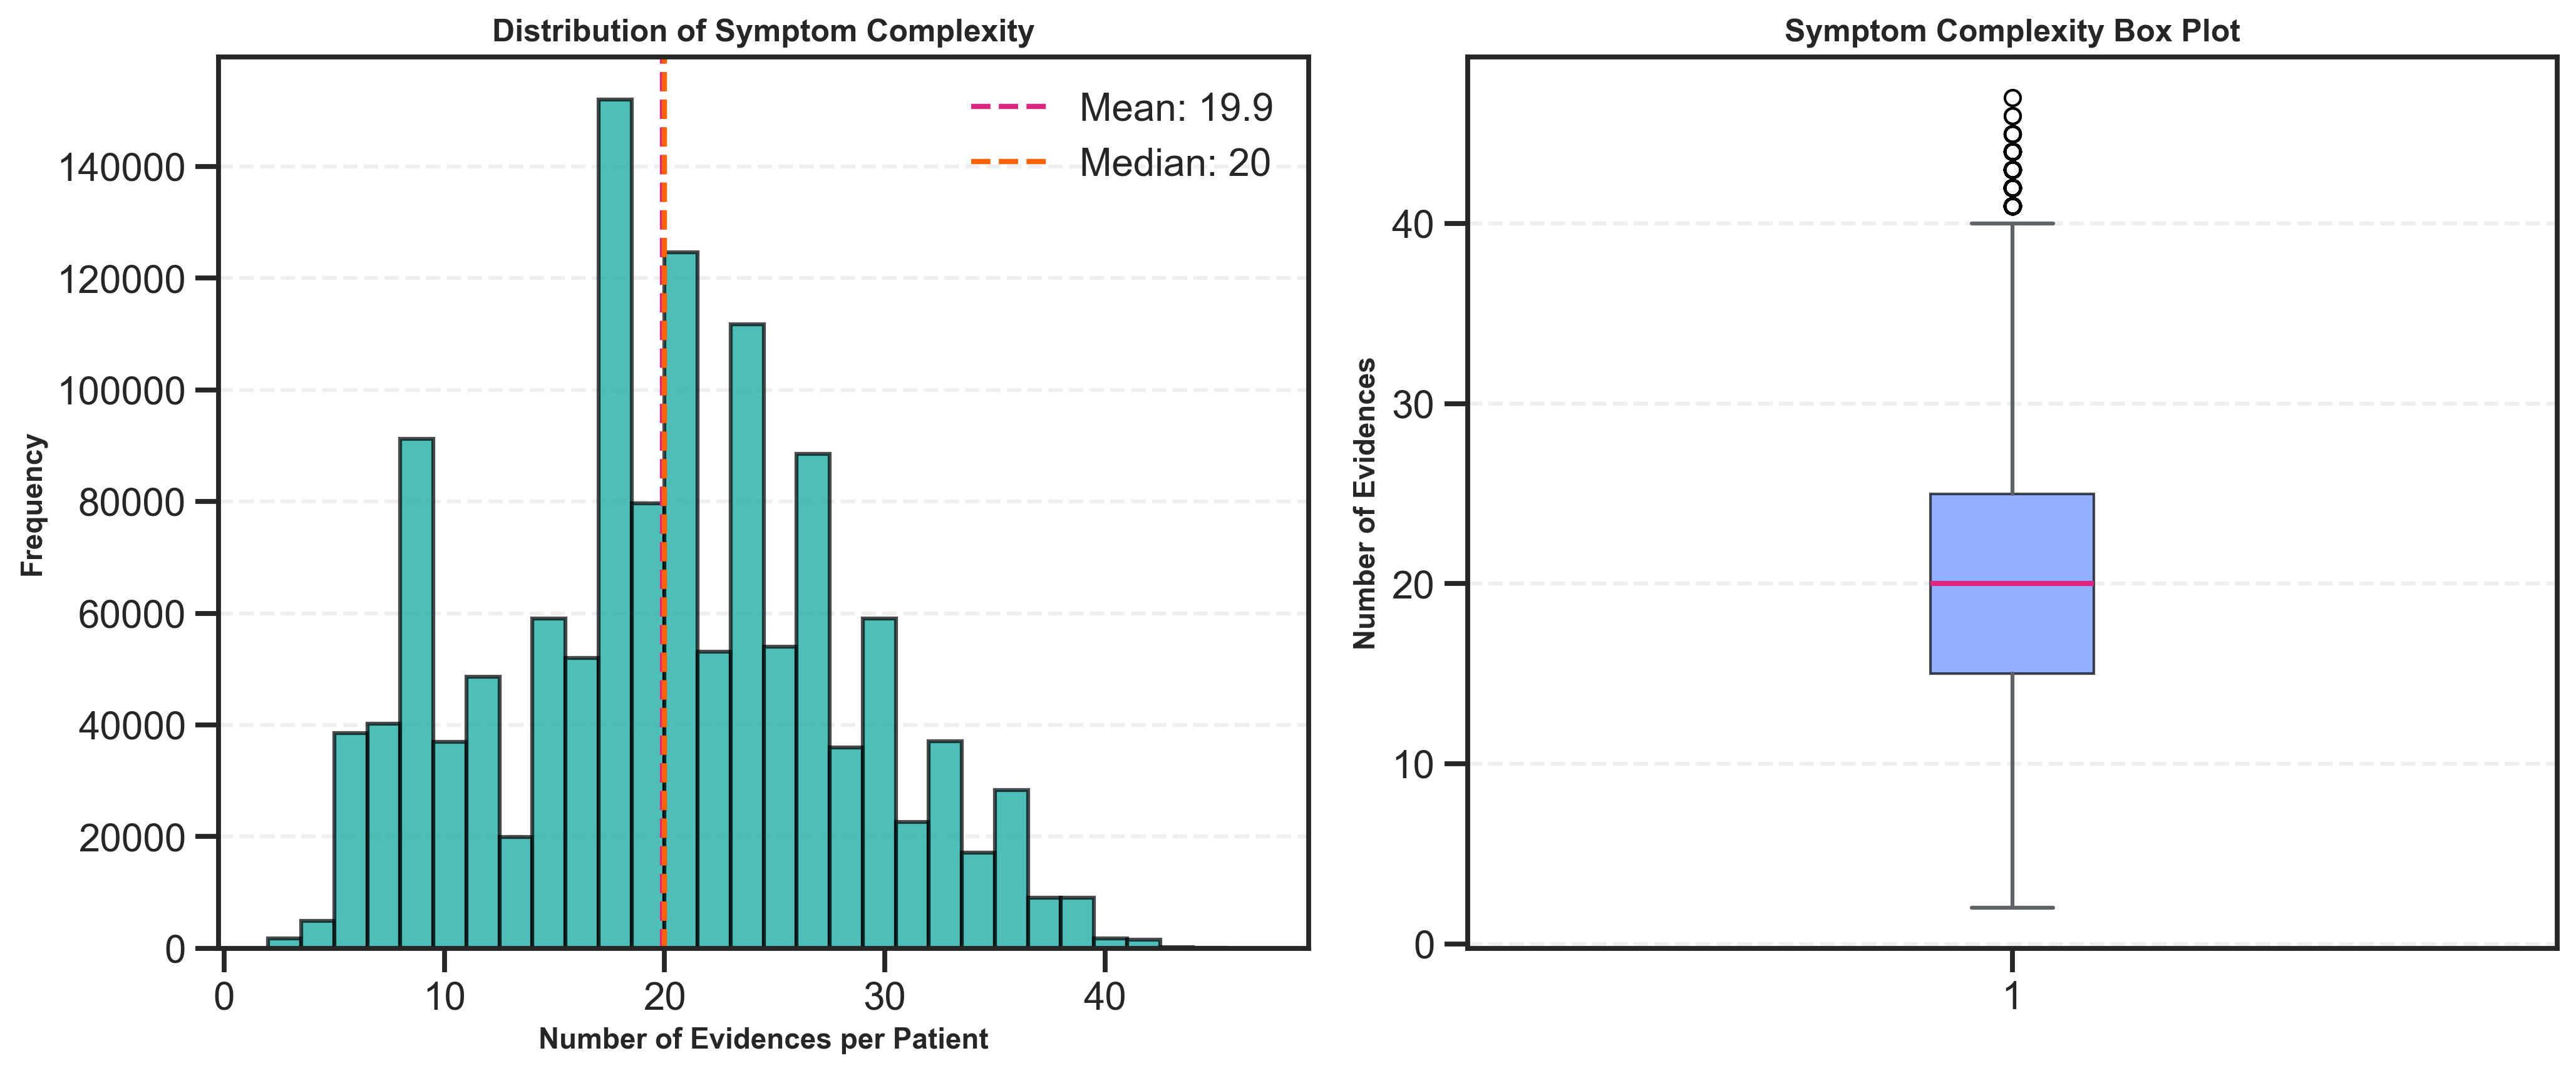

✓ Figure 3 saved: figures/03_symptom_complexity.png

Symptom statistics:
  Mean:   19.9
  Median: 20
  Range:  2-47


In [31]:
# Figure 3: Symptom Complexity Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE, dpi=DPI)

# Subplot 1: Histogram
ax1.hist(df_all['num_evidences'], bins=30, color=IBM_COLORS['teal'], 
         edgecolor='black', alpha=0.7)

ax1.axvline(df_all['num_evidences'].mean(), color=IBM_COLORS['magenta'], 
           linestyle='--', linewidth=2, label=f'Mean: {df_all["num_evidences"].mean():.1f}')
ax1.axvline(df_all['num_evidences'].median(), color=IBM_COLORS['orange'], 
           linestyle='--', linewidth=2, label=f'Median: {df_all["num_evidences"].median():.0f}')

ax1.set_xlabel('Number of Evidences per Patient', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Symptom Complexity', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Subplot 2: Box plot
ax2.boxplot(df_all['num_evidences'], vert=True, patch_artist=True,
           boxprops=dict(facecolor=IBM_COLORS['blue'], alpha=0.7),
           medianprops=dict(color=IBM_COLORS['magenta'], linewidth=2),
           whiskerprops=dict(color=IBM_COLORS['gray'], linewidth=1.5),
           capprops=dict(color=IBM_COLORS['gray'], linewidth=1.5))

ax2.set_ylabel('Number of Evidences', fontsize=11, fontweight='bold')
ax2.set_title('Symptom Complexity Box Plot', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/03_symptom_complexity.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: figures/03_symptom_complexity.png")
print(f"\nSymptom statistics:")
print(f"  Mean:   {df_all['num_evidences'].mean():.1f}")
print(f"  Median: {df_all['num_evidences'].median():.0f}")
print(f"  Range:  {df_all['num_evidences'].min()}-{df_all['num_evidences'].max()}")


C:\Users\julia\AppData\Local\Temp\ipykernel_25304\1000609736.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(age_symptom_data, labels=['0-17', '18-34', '35-49', '50-64', '65+'],
C:\Users\julia\AppData\Local\Temp\ipykernel_25304\1000609736.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(sex_symptom_data, labels=['Male', 'Female'],


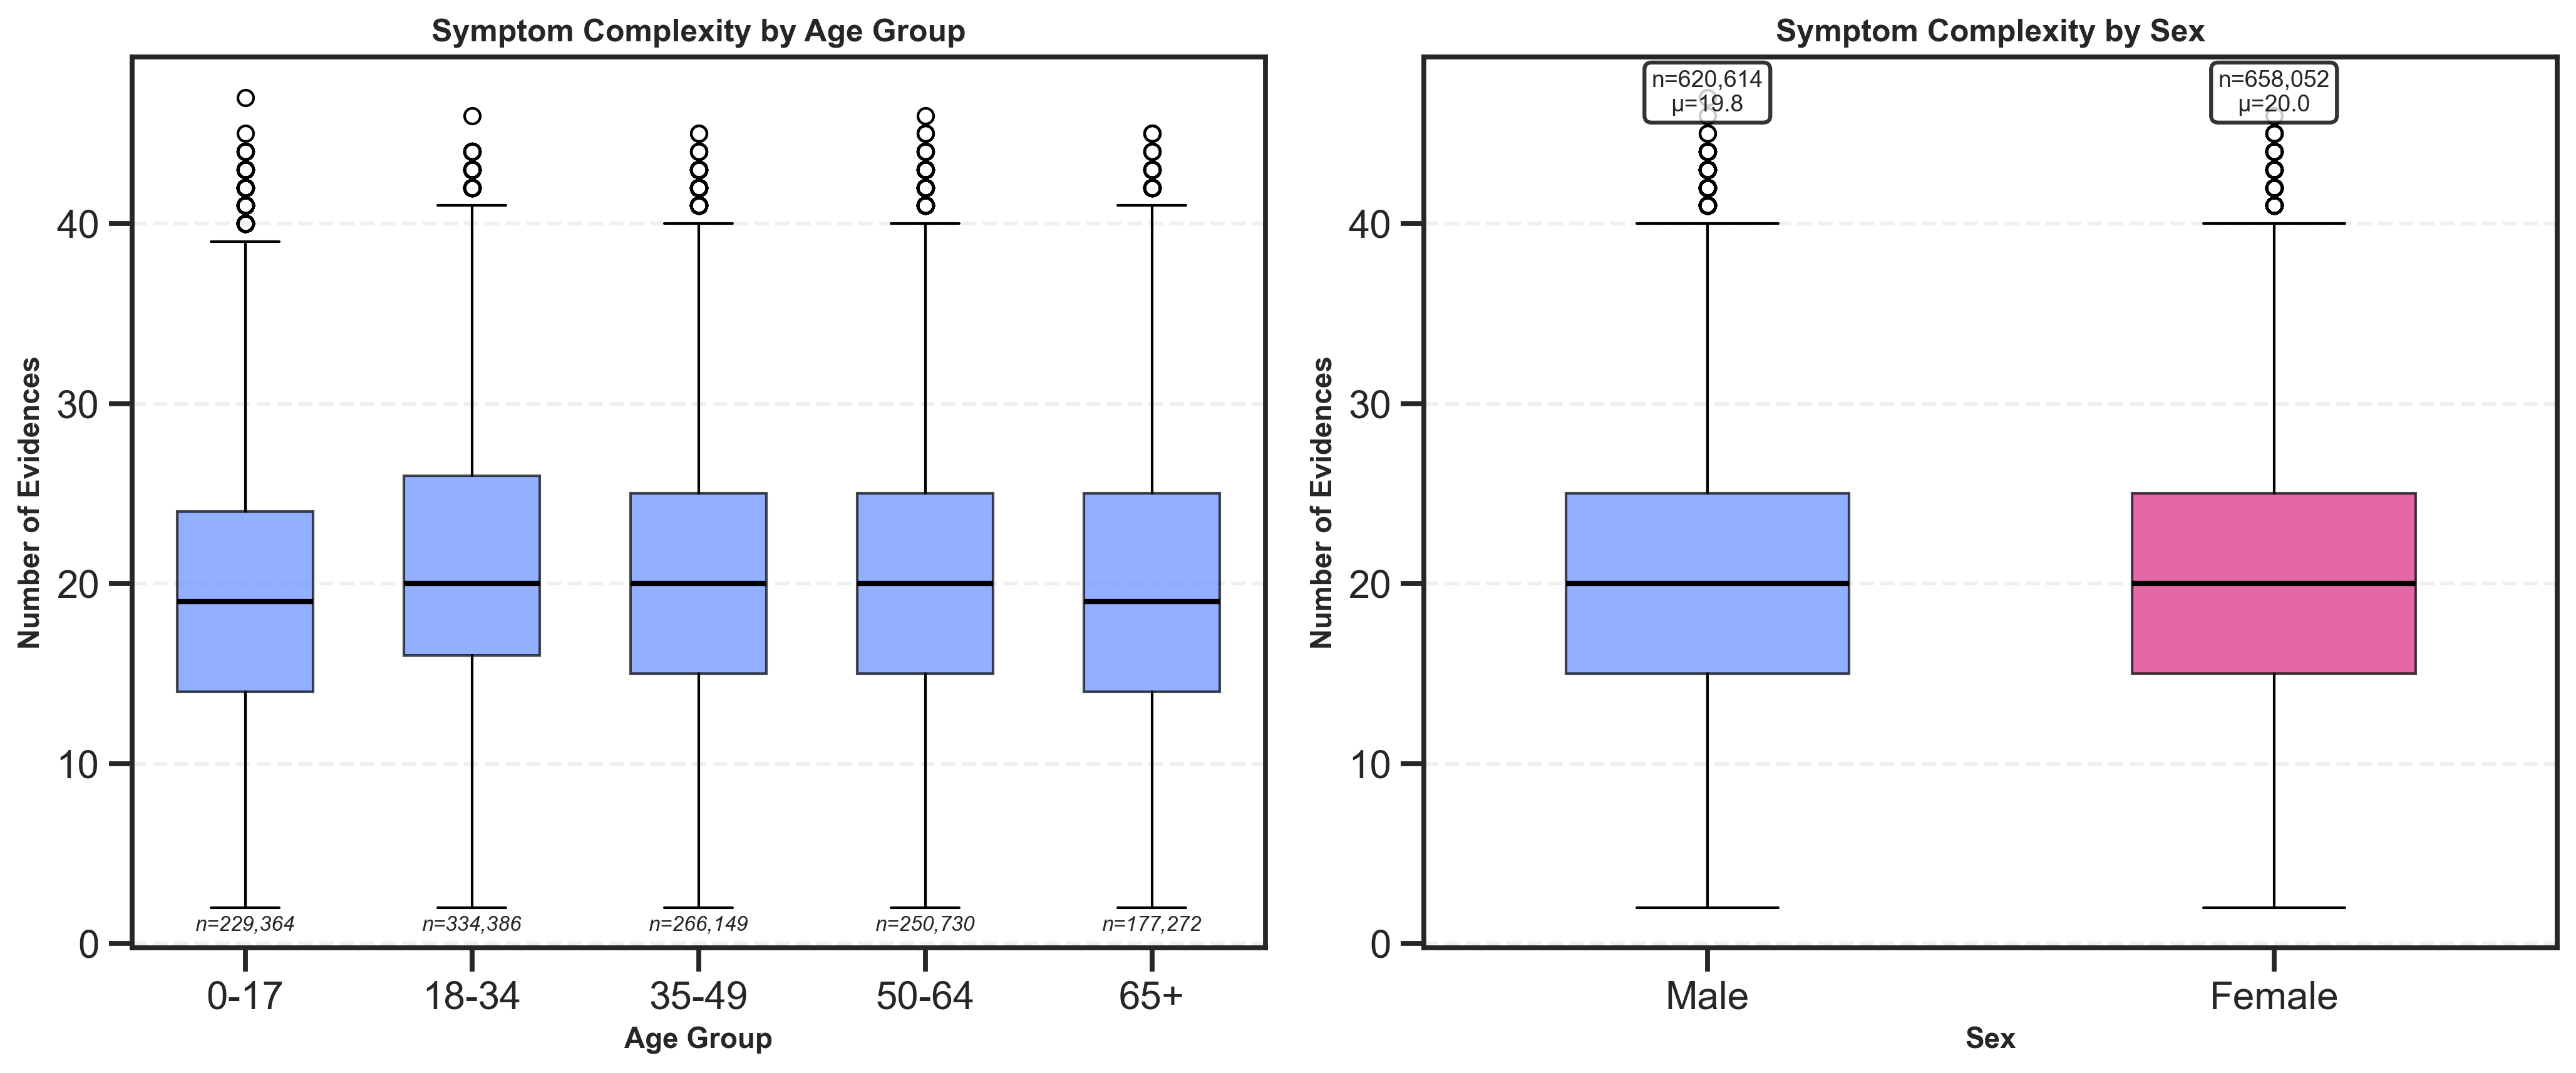

✓ Figure 4 saved: figures/04_symptom_complexity_demographics.png


In [32]:
# Figure 4: Symptom Complexity by Demographics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE, dpi=DPI)

# LEFT: Symptoms by Age Groups
# Create age bins
df_all['age_group'] = pd.cut(df_all['AGE'], 
                               bins=[0, 18, 35, 50, 65, 110],
                               labels=['0-17', '18-34', '35-49', '50-64', '65+'])

age_symptom_data = [df_all[df_all['age_group'] == group]['num_evidences'].values 
                    for group in ['0-17', '18-34', '35-49', '50-64', '65+']]

bp1 = ax1.boxplot(age_symptom_data, labels=['0-17', '18-34', '35-49', '50-64', '65+'],
                   patch_artist=True, widths=0.6)

# Color boxes
for patch in bp1['boxes']:
    patch.set_facecolor(IBM_COLORS['blue'])
    patch.set_alpha(0.7)
for median in bp1['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax1.set_xlabel('Age Group', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Evidences', fontsize=11, fontweight='bold')
ax1.set_title('Symptom Complexity by Age Group', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Add sample sizes
for i, group in enumerate(['0-17', '18-34', '35-49', '50-64', '65+']):
    n = len(df_all[df_all['age_group'] == group])
    ax1.text(i+1, ax1.get_ylim()[0] + 1, f'n={n:,}', 
            ha='center', fontsize=8, style='italic')

# RIGHT: Symptoms by Sex
sex_symptom_data = [df_all[df_all['SEX'] == sex]['num_evidences'].values 
                    for sex in ['M', 'F']]

bp2 = ax2.boxplot(sex_symptom_data, labels=['Male', 'Female'],
                   patch_artist=True, widths=0.5)

# Color boxes differently
bp2['boxes'][0].set_facecolor(IBM_COLORS['blue'])
bp2['boxes'][1].set_facecolor(IBM_COLORS['magenta'])
for patch in bp2['boxes']:
    patch.set_alpha(0.7)
for median in bp2['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.set_xlabel('Sex', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Evidences', fontsize=11, fontweight='bold')
ax2.set_title('Symptom Complexity by Sex', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Add statistics
for i, sex in enumerate(['M', 'F']):
    data = df_all[df_all['SEX'] == sex]['num_evidences']
    n = len(data)
    mean = data.mean()
    ax2.text(i+1, ax2.get_ylim()[1] - 3, 
            f'n={n:,}\nμ={mean:.1f}', 
            ha='center', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/04_symptom_complexity_demographics.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved: figures/04_symptom_complexity_demographics.png")

# Drop temporary column
df_all.drop('age_group', axis=1, inplace=True)


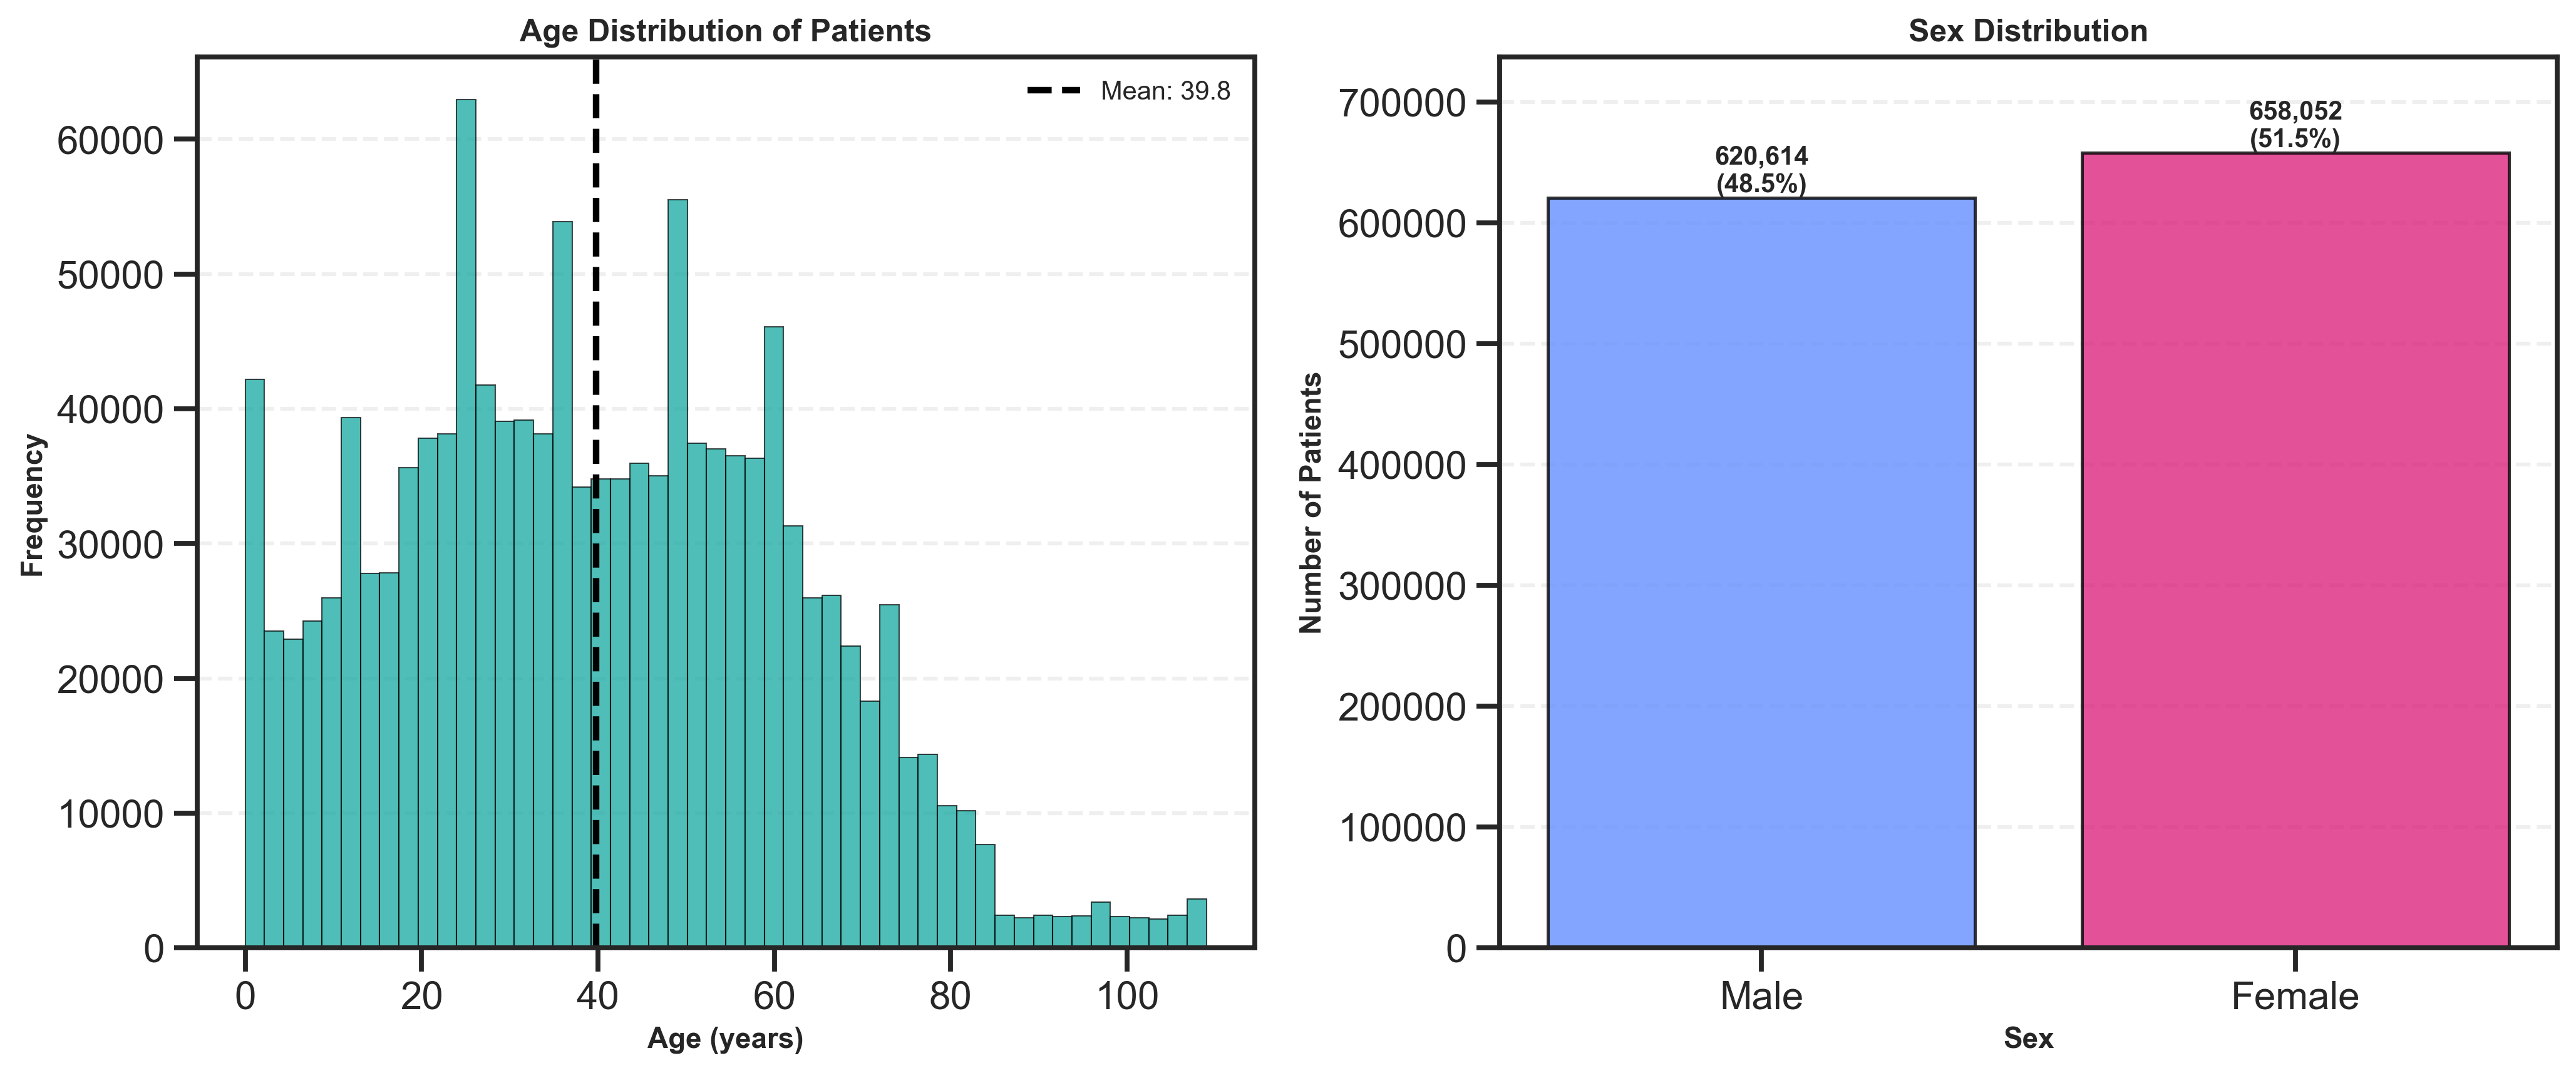

✓ Figure 5 saved: figures/05_demographics.png


In [33]:
# Figure 5: Demographics Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE, dpi=DPI)

# LEFT: Age distribution
ax1.hist(df_all['AGE'], bins=50, color=IBM_COLORS['teal'], 
         edgecolor='black', alpha=0.7, linewidth=0.5)

# Mean line (black)
mean_age = df_all['AGE'].mean()
ax1.axvline(mean_age, color='black', 
           linestyle='--', linewidth=2.5, label=f'Mean: {mean_age:.1f}')

ax1.set_xlabel('Age (years)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Age Distribution of Patients', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# RIGHT: Sex distribution
sex_counts = df_all['SEX'].value_counts()
# Order: Male first, then Female (to match colors with Figure 3)
sex_order = ['M', 'F']
sex_labels = ['Male', 'Female']
sex_values = [sex_counts['M'], sex_counts['F']]
colors_sex = [IBM_COLORS['blue'], IBM_COLORS['magenta']]

bars = ax2.bar(sex_labels, sex_values, color=colors_sex, 
              edgecolor='black', linewidth=1.2, alpha=0.8)

ax2.set_xlabel('Sex', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax2.set_title('Sex Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Set y-limit for better proportions
ax2.set_ylim(0, max(sex_values) * 1.12)

# Add value labels ON TOP of bars
for bar, value in zip(bars, sex_values):
    height = bar.get_height()
    percentage = (value / len(df_all)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/05_demographics.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 5 saved: figures/05_demographics.png")


**Observation:** Symptom complexity is remarkably consistent across demographics:
- Age groups: All medians around 19-20 symptoms
- Sex: Males (μ=19.8) vs Females (μ=20.0) - negligible difference

**Implication for modeling:** Demographics alone are NOT predictive of symptom complexity. This validates that the diagnostic assistant must rely primarily on symptom patterns rather than patient demographics.


C:\Users\julia\AppData\Local\Temp\ipykernel_25304\3572185411.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(symptom_by_disease, labels=top_diseases, patch_artist=True,


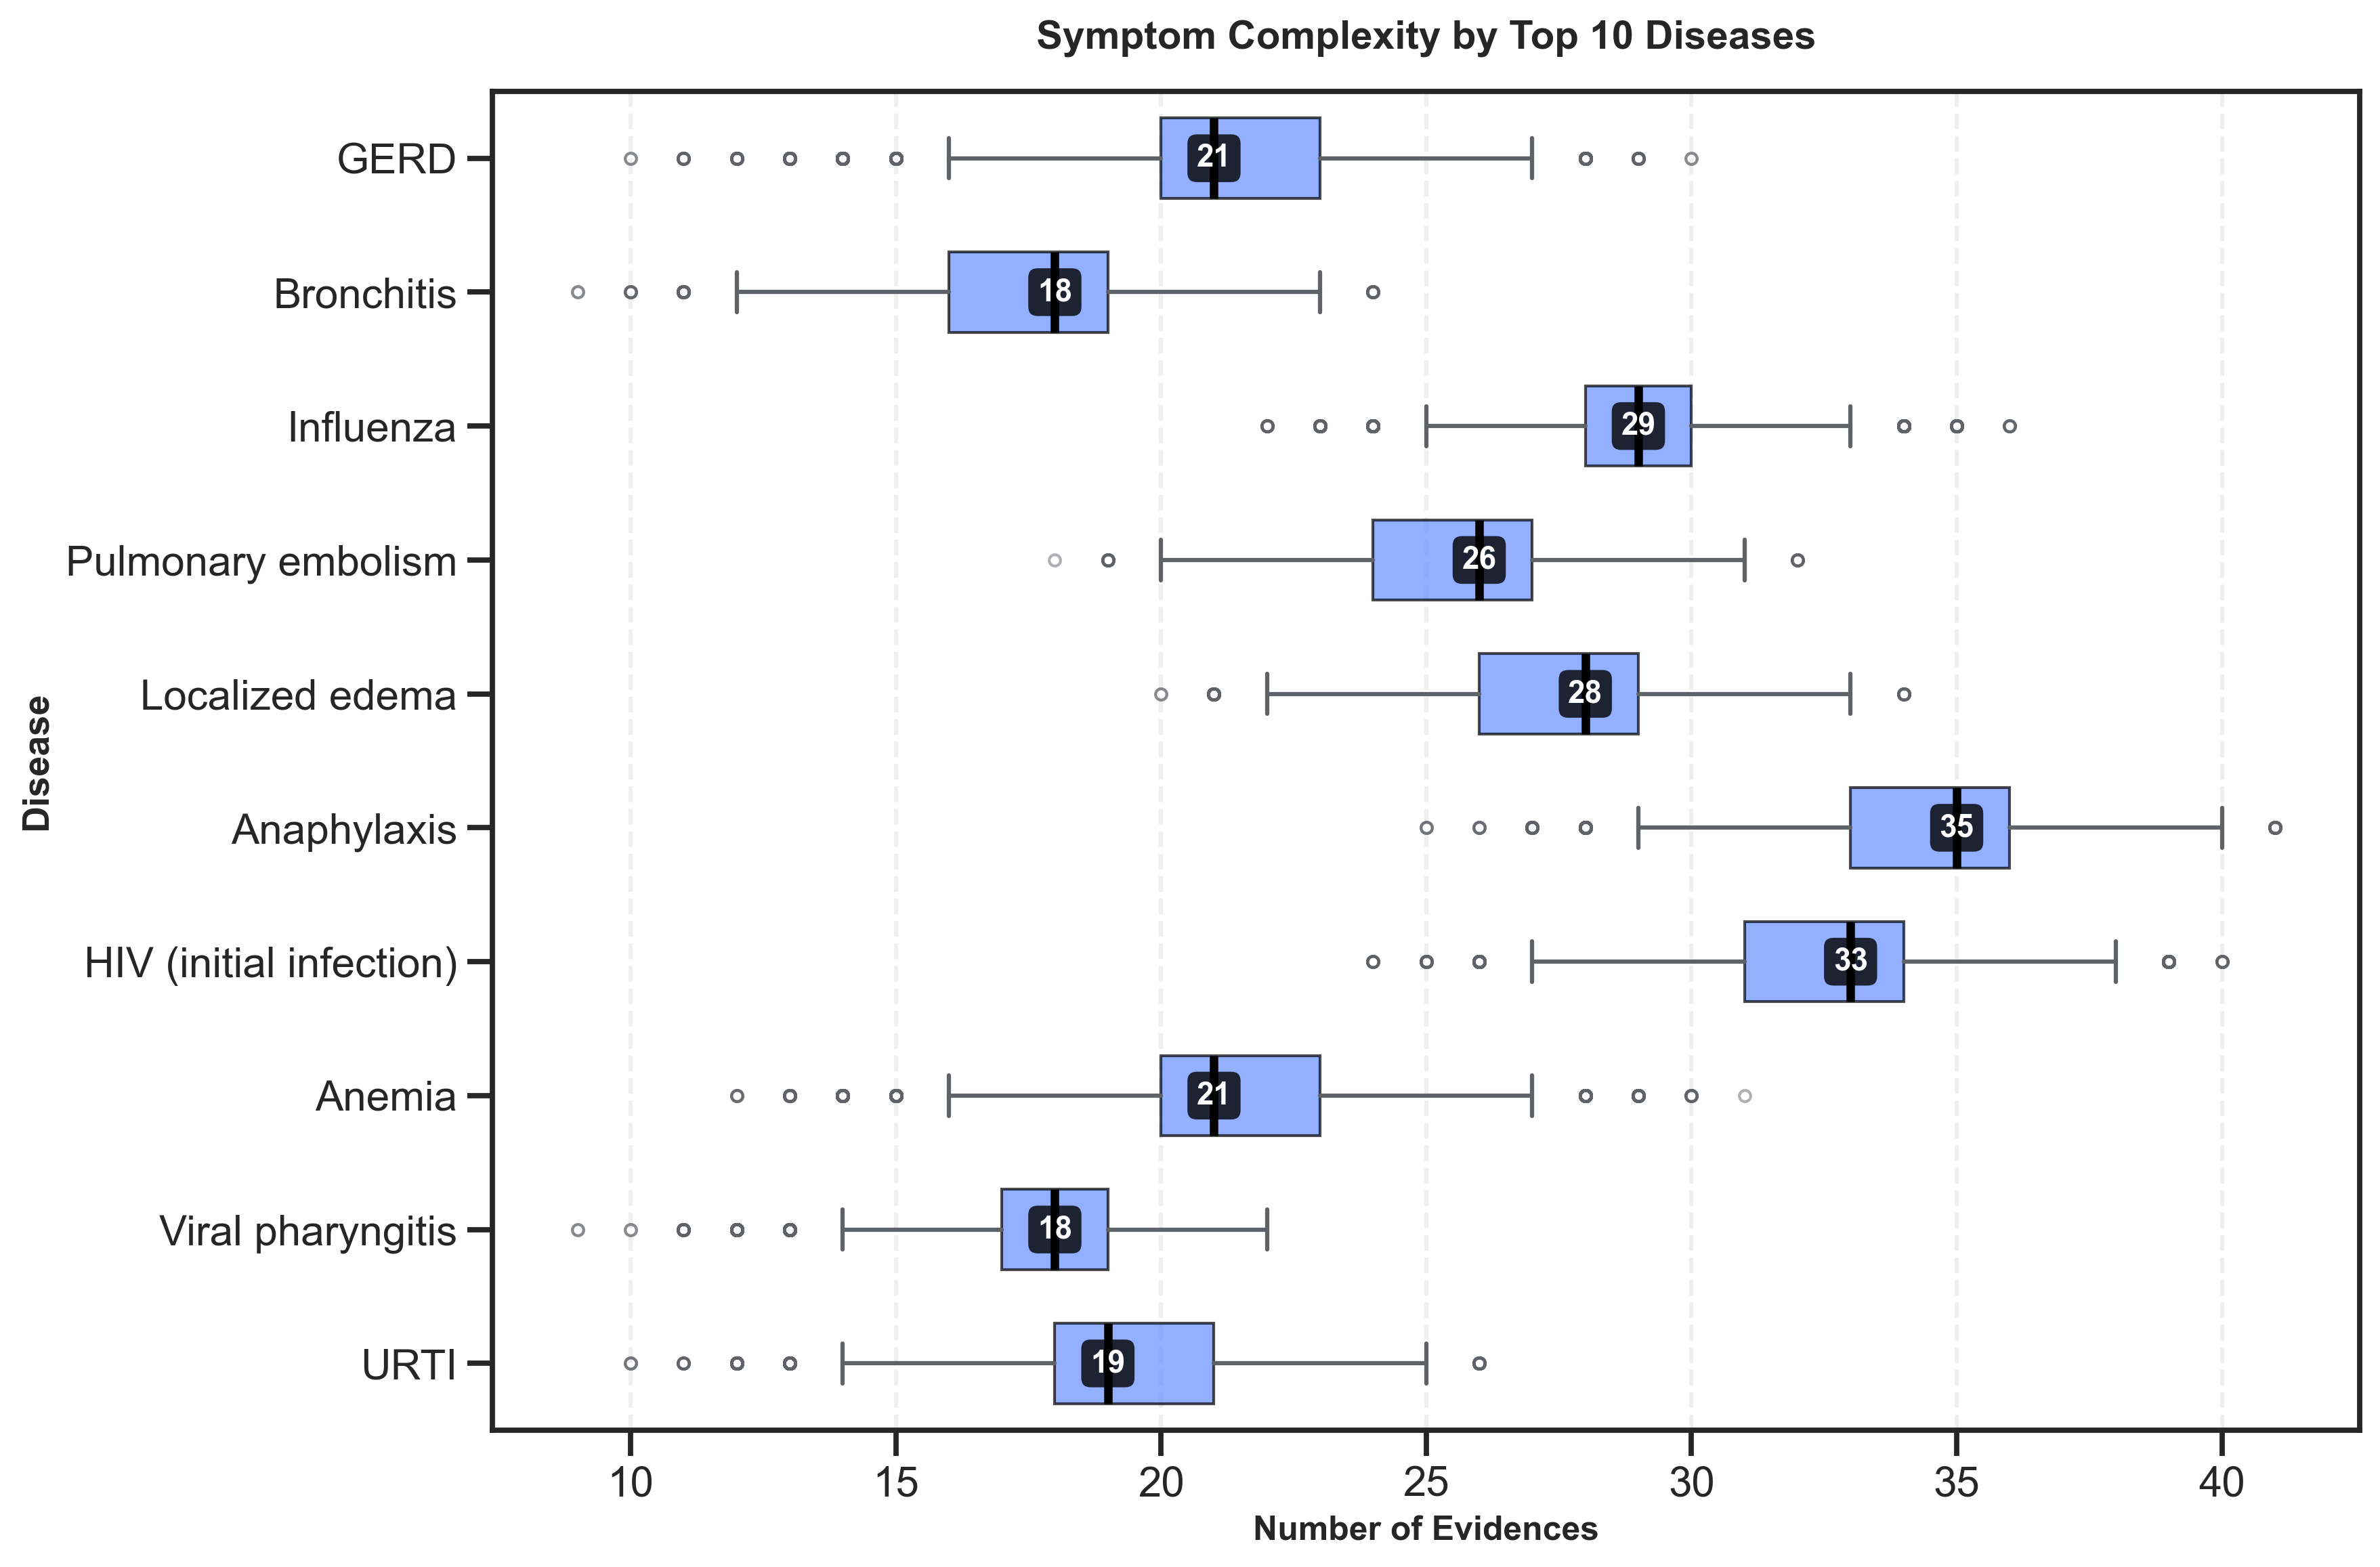

✓ Figure 6 saved: figures/06_symptom_complexity_by_disease.png

Key Insights:
  URTI                     : Median 19 symptoms
  Viral pharyngitis        : Median 18 symptoms
  Anemia                   : Median 21 symptoms
  HIV (initial infection)  : Median 33 symptoms
  Anaphylaxis              : Median 35 symptoms
  Localized edema          : Median 28 symptoms
  Pulmonary embolism       : Median 26 symptoms
  Influenza                : Median 29 symptoms
  Bronchitis               : Median 18 symptoms
  GERD                     : Median 21 symptoms


In [34]:
# Figure 6: Symptom Complexity by Top 10 Diseases
fig, ax = plt.subplots(figsize=(12, 8), dpi=DPI)

# Get top 10 diseases
top_diseases = df_all['PATHOLOGY'].value_counts().head(10).index

# Create data for box plots
symptom_by_disease = [df_all[df_all['PATHOLOGY'] == disease]['num_evidences'].values 
                      for disease in top_diseases]

bp = ax.boxplot(symptom_by_disease, labels=top_diseases, patch_artist=True,
                vert=False, widths=0.6)

# Color boxes
for patch in bp['boxes']:
    patch.set_facecolor(IBM_COLORS['blue'])
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Style medians - BLACK and THICK
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(3)

# Style whiskers and caps
for whisker in bp['whiskers']:
    whisker.set_color(IBM_COLORS['gray'])
    whisker.set_linewidth(1.5)
for cap in bp['caps']:
    cap.set_color(IBM_COLORS['gray'])
    cap.set_linewidth(1.5)

# Style outliers
for flier in bp['fliers']:
    flier.set_marker('o')
    flier.set_markerfacecolor('none')
    flier.set_markeredgecolor(IBM_COLORS['gray'])
    flier.set_markersize(4)
    flier.set_alpha(0.5)

ax.set_xlabel('Number of Evidences', fontsize=12, fontweight='bold')
ax.set_ylabel('Disease', fontsize=13, fontweight='bold')  # Bigger y-axis label
ax.set_title('Symptom Complexity by Top 10 Diseases', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add median values INSIDE boxes (white text, bold)
for i, disease in enumerate(top_diseases):
    median_val = df_all[df_all['PATHOLOGY'] == disease]['num_evidences'].median()
    # Position text in center of box
    ax.text(median_val, i+1, f'{median_val:.0f}', 
           va='center', ha='center', fontsize=11, fontweight='bold',
           color='white',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='black', edgecolor='none', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/06_symptom_complexity_by_disease.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 6 saved: figures/06_symptom_complexity_by_disease.png")

# Print insights
print("\nKey Insights:")
for disease in top_diseases:
    median_symp = df_all[df_all['PATHOLOGY'] == disease]['num_evidences'].median()
    print(f"  {disease:25s}: Median {median_symp:.0f} symptoms")


## 5. Evidence & Condition Analysis

**Purpose:** Understand symptom/finding structure and condition mappings for feature engineering.


In [35]:
# 5.1 Evidence Mapping Overview
print("="*70)
print("EVIDENCE MAPPING STRUCTURE")
print("="*70)

print(f"Total evidence codes in mapping: {len(evidences)}")

# Show example structure
sample_code = 'E_48'
if sample_code in evidences:
    print(f"\nExample evidence: {sample_code}")
    print(json.dumps(evidences[sample_code], indent=2))


EVIDENCE MAPPING STRUCTURE
Total evidence codes in mapping: 223

Example evidence: E_48
{
  "name": "E_48",
  "code_question": "E_48",
  "question_fr": "Habitez-vous avec 4 personnes ou plus?",
  "question_en": "Do you live with 4 or more people?",
  "is_antecedent": true,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}


In [36]:
# 5.2 Evidence Type Breakdown
print("\n" + "="*70)
print("EVIDENCE TYPE ANALYSIS")
print("="*70)

# Count by data type
evidence_types = {}
for code, info in evidences.items():
    dtype = info.get('data_type', 'unknown')
    evidence_types[dtype] = evidence_types.get(dtype, 0) + 1

print("Evidence types:")
for etype, count in sorted(evidence_types.items(), key=lambda x: x[1], reverse=True):
    percentage = count / len(evidences) * 100
    print(f"  {etype:20s}: {count:3d} codes ({percentage:5.1f}%)")

# Binary, Categorical, Multi-choice breakdown
print("\nType meanings:")
print("  B (Binary):      Yes/No questions")
print("  C (Categorical): Single choice from multiple options")  
print("  M (Multi-choice): Multiple selections possible")

# Count evidences with value mappings (categorical)
categorical_evidences = [k for k, v in evidences.items() if v.get('possible-values')]
print(f"\nCategorical evidences with value mappings: {len(categorical_evidences)}")



EVIDENCE TYPE ANALYSIS
Evidence types:
  B                   : 208 codes ( 93.3%)
  C                   :  10 codes (  4.5%)
  M                   :   5 codes (  2.2%)

Type meanings:
  B (Binary):      Yes/No questions
  C (Categorical): Single choice from multiple options
  M (Multi-choice): Multiple selections possible

Categorical evidences with value mappings: 15


VISUALIZING EVIDENCE TYPE DISTRIBUTION


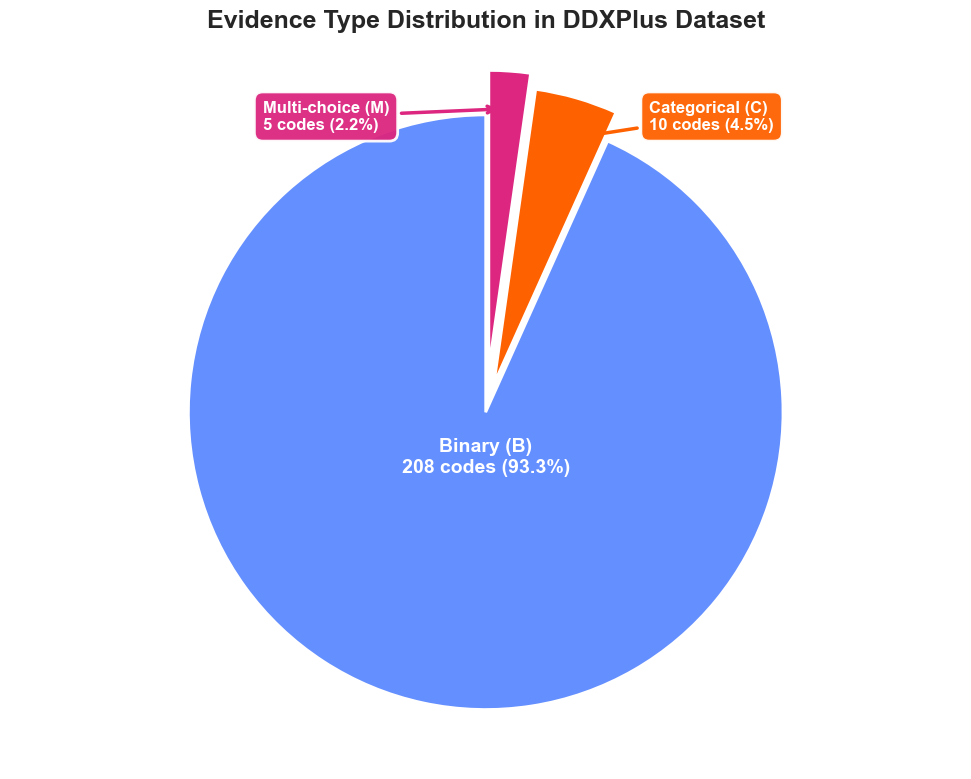


✓ Saved: figures/07_evidence_type_distribution_pie.png


In [71]:
# Section 5.2 - Evidence Type Distribution Visualization
import numpy as np

print("="*70)
print("VISUALIZING EVIDENCE TYPE DISTRIBUTION")
print("="*70)

# Prepare data
type_counts = pd.Series([v.get("data_type","UNK") for v in evidences.values()]).value_counts()
# expected keys: B, C, M

counts = np.array([type_counts.get("B",0), type_counts.get("C",0), type_counts.get("M",0)])
labels = ["Binary (B)", "Categorical (C)", "Multi-choice (M)"]
percentages = (counts/counts.sum())*100


# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Use IBM colorblind-safe colors
colors = [IBM_COLORS['blue'], IBM_COLORS['orange'], IBM_COLORS['magenta']]

# Create pie chart with exploded small slices
explode = (0, 0.1, 0.15)

wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,
    autopct='',
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Binary (B) - INSIDE the pie chart
ax.text(0, -0.15, f'{labels[0]}\n{counts[0]} codes ({percentages[0]:.1f}%)', 
        ha='center', va='center', 
        fontsize=14, weight='bold', color='white')

# Categorical (C) - RIGHT side with precise arrow
ax.annotate(f'{labels[1]}\n{counts[1]} codes ({percentages[1]:.1f}%)', 
            xy=(0.28, 0.92),       # Arrow tip position (on orange slice)
            xytext=(0.55, 0.95),   # Text box position (right side)
            fontsize=12, 
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=IBM_COLORS['orange'], 
                     edgecolor='white', linewidth=2, alpha=0.95),
            color='white',
            arrowprops=dict(arrowstyle='->', lw=2.5, color=IBM_COLORS['orange']))

# Multi-choice (M) - LEFT side with precise arrow
ax.annotate(f'{labels[2]}\n{counts[2]} codes ({percentages[2]:.1f}%)', 
            xy=(0.05, 1.02),        # Arrow tip position (on magenta slice)
            xytext=(-0.75, 0.95),   # Text box position (left side)
            fontsize=12, 
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor=IBM_COLORS['magenta'], 
                     edgecolor='white', linewidth=2, alpha=0.95),
            color='white',
            arrowprops=dict(arrowstyle='->', lw=2.5, color=IBM_COLORS['magenta']))

ax.set_title('Evidence Type Distribution in DDXPlus Dataset', 
             fontsize=18, weight='bold', pad=20)

# Set equal aspect ratio and adjust limits for better spacing
ax.set_aspect('equal')
plt.xlim(-1.6, 1.6)
plt.ylim(-1.2, 1.2)


plt.tight_layout()
plt.savefig('figures/07_evidence_type_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/07_evidence_type_distribution_pie.png")


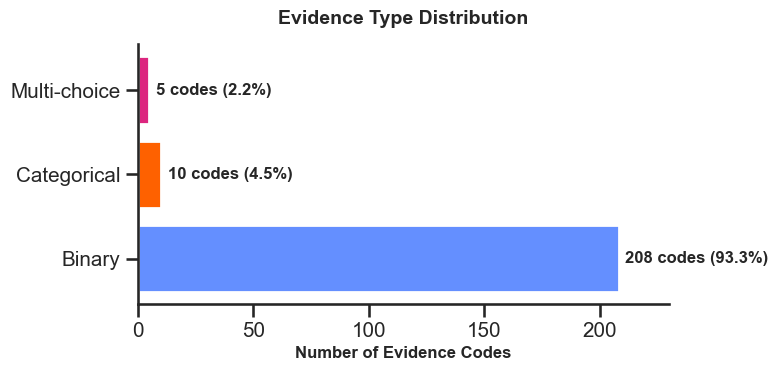


✓ Saved: figures/07_evidence_type_distribution_bar.png


In [74]:
# Alternative: Compact horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 4))

# Prepare data
# Prepare data
type_counts = pd.Series([v.get("data_type","UNK") for v in evidences.values()]).value_counts()
# expected keys: B, C, M

counts = np.array([type_counts.get("B",0), type_counts.get("C",0), type_counts.get("M",0)])
labels = ["Binary", "Categorical", "Multi-choice"]
percentages = (counts/counts.sum())*100
colors_bar = [IBM_COLORS['blue'], IBM_COLORS['orange'], IBM_COLORS['magenta']]

# Create horizontal bar
bars = ax.barh(labels, counts, color=colors_bar, edgecolor='white', linewidth=2)

# Add count and percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
    ax.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2, 
            f'{count} codes ({pct:.1f}%)', 
            va='center', fontsize=12, weight='bold')

ax.set_xlabel('Number of Evidence Codes', fontsize=12, weight='bold')
ax.set_title('Evidence Type Distribution', fontsize=14, weight='bold', pad=15)
ax.set_xlim(0, 230)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/07_evidence_type_distribution_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/07_evidence_type_distribution_bar.png")


In [39]:
# Display examples of each evidence type
print("\n" + "="*70)
print("EVIDENCE EXAMPLES")
print("="*70)

# Count by data type
binary_evidences = []
categorical_evidences = []
multichoice_evidences = []

for code, info in evidences.items():
    dtype = info['data_type']
    if dtype == 'B':
        binary_evidences.append(code)
    elif dtype == 'C':
        categorical_evidences.append(code)
    elif dtype == 'M':
        multichoice_evidences.append(code)

# ============================================================================
# 1. BINARY EVIDENCES
# ============================================================================
print("\n1. BINARY EVIDENCES (Yes/No questions)")
print("-" * 70)

for i, code in enumerate(binary_evidences[:3], 1):
    ev = evidences[code]
    print(f"\nExample {i}: {code}")
    print(f"  Question: {ev['question_en']}")
    print(f"  Is antecedent: {ev['is_antecedent']}")
    print(f"  Default value: {ev['default_value']}")

# ============================================================================
# 2. CATEGORICAL EVIDENCES
# ============================================================================
print("\n2. CATEGORICAL EVIDENCES (Single choice)")
print("-" * 70)

if categorical_evidences:
    for i, code in enumerate(categorical_evidences[:3], 1):
        ev = evidences[code]
        print(f"\nExample {i}: {code}")
        print(f"  Question: {ev['question_en']}")
        print(f"  Is antecedent: {ev['is_antecedent']}")
        
        # Show possible values if they exist
        if 'possible-values' in ev:
            print(f"  Possible values: {ev['possible-values'][:5]}")  # First 5
        
        # Show value meanings if they exist
        if 'value_meaning' in ev and ev['value_meaning']:
            print(f"  Value meanings (sample):")
            for j, (val_code, meaning) in enumerate(list(ev['value_meaning'].items())[:3], 1):
                print(f"    {val_code}: {meaning}")
            if len(ev['value_meaning']) > 3:
                print(f"    ... and {len(ev['value_meaning']) - 3} more values")
else:
    print("  No categorical evidences found in dataset")

# ============================================================================
# 3. MULTI-CHOICE EVIDENCES
# ============================================================================
print("\n3. MULTI-CHOICE EVIDENCES (Multiple selections)")
print("-" * 70)

if multichoice_evidences:
    for i, code in enumerate(multichoice_evidences[:3], 1):
        ev = evidences[code]
        print(f"\nExample {i}: {code}")
        print(f"  Question: {ev['question_en']}")
        print(f"  Is antecedent: {ev['is_antecedent']}")
        
        # Show possible values if they exist
        if 'possible-values' in ev:
            print(f"  Possible values: {ev['possible-values'][:5]}")  # First 5
        
        # Show value meanings if they exist
        if 'value_meaning' in ev and ev['value_meaning']:
            print(f"  Value meanings (sample):")
            for j, (val_code, meaning) in enumerate(list(ev['value_meaning'].items())[:3], 1):
                print(f"    {val_code}: {meaning}")
            if len(ev['value_meaning']) > 3:
                print(f"    ... and {len(ev['value_meaning']) - 3} more values")
else:
    print("  No multi-choice evidences found in dataset")

# Summary
print("\n" + "="*70)
print("EVIDENCE TYPE SUMMARY")
print("="*70)
print(f"Binary evidences: {len(binary_evidences)}")
print(f"Categorical evidences: {len(categorical_evidences)}")
print(f"Multi-choice evidences: {len(multichoice_evidences)}")
print(f"Total: {len(binary_evidences) + len(categorical_evidences) + len(multichoice_evidences)}")



EVIDENCE EXAMPLES

1. BINARY EVIDENCES (Yes/No questions)
----------------------------------------------------------------------

Example 1: E_91
  Question: Do you have a fever (either felt or measured with a thermometer)?
  Is antecedent: False
  Default value: 0

Example 2: E_53
  Question: Do you have pain somewhere, related to your reason for consulting?
  Is antecedent: False
  Default value: 0

Example 3: E_159
  Question: Did you lose consciousness?
  Is antecedent: False
  Default value: 0

2. CATEGORICAL EVIDENCES (Single choice)
----------------------------------------------------------------------

Example 1: E_59
  Question: How fast did the pain appear?
  Is antecedent: False
  Possible values: [0, 1, 2, 3, 4]

Example 2: E_56
  Question: How intense is the pain?
  Is antecedent: False
  Possible values: [0, 1, 2, 3, 4]

Example 3: E_58
  Question: How precisely is the pain located?
  Is antecedent: False
  Possible values: [0, 1, 2, 3, 4]

3. MULTI-CHOICE EVIDENCES (Mul

In [40]:
df_all.columns

Index(['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES',
       'INITIAL_EVIDENCE', 'split', 'EVIDENCES_list',
       'DIFFERENTIAL_DIAGNOSIS_list', 'num_evidences', 'frequency'],
      dtype='object')

In [65]:
# Section 5.3 Check: Is INITIAL_EVIDENCE always in the EVIDENCES list?
print("Verifying INITIAL_EVIDENCE definition...")

def to_base(code: str) -> str:
    return code.split("_@_")[0]  # safe for both base and value-coded

# Test: Is initial evidence always part of all evidences?
def check_initial_in_evidences(row):
    initial = row["INITIAL_EVIDENCE"]
    base_set = {to_base(c) for c in row["EVIDENCES_list"]}
    return initial in base_set

in_list = df_all.apply(check_initial_in_evidences, axis=1)


print(f"\nIs INITIAL_EVIDENCE always in EVIDENCES list?")
print(f"  Yes: {in_list.sum():,} patients ({in_list.sum()/len(df_all)*100:.1f}%)")
print(f"  No:  {(~in_list).sum():,} patients ({(~in_list).sum()/len(df_all)*100:.1f}%)")

if in_list.all():
    print("\n✓ CONFIRMED: INITIAL_EVIDENCE is always included in EVIDENCES")
    print("  → It's the 'chief complaint' - what patient presented with")
else:
    print("\n⚠ WARNING: INITIAL_EVIDENCE sometimes NOT in EVIDENCES list")
    print("  → May have different meaning than 'first symptom'")

# Check a few examples
print("\n\nExample patients:")
for i in range(3):
    patient = df_all.iloc[i]
    print(f"\nPatient {i}:")
    print(f"  Initial: {patient['INITIAL_EVIDENCE']}")
    print(f"  All evidences: {patient['EVIDENCES_list'][:]}...")
    print(f"  Is initial in list? {patient['INITIAL_EVIDENCE'] in patient['EVIDENCES']}")


Verifying INITIAL_EVIDENCE definition...

Is INITIAL_EVIDENCE always in EVIDENCES list?
  Yes: 1,278,666 patients (100.0%)
  No:  0 patients (0.0%)

✓ CONFIRMED: INITIAL_EVIDENCE is always included in EVIDENCES
  → It's the 'chief complaint' - what patient presented with


Example patients:

Patient 0:
  Initial: E_91
  All evidences: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_V_167', 'E_56_@_4', 'E_57_@_V_123', 'E_58_@_3', 'E_59_@_3', 'E_77', 'E_79', 'E_91', 'E_97', 'E_201', 'E_204_@_V_10', 'E_222']...
  Is initial in list? True

Patient 1:
  Initial: E_50
  All evidences: ['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_@_V_198', 'E_55_@_V_62', 'E_55_@_V_166', 'E_55_@_V_167', 'E_56_@_7', 'E_57_@_V_123', 'E_58_@_7', 'E_59_@_2', 'E_91', 'E_115', 'E_129', 'E_130_@_V_138', 'E_131_@_V_10', 'E_132_@_0', 'E_133_@_V_90', 'E_133_@_V_91', 'E_133_@_V_95', 'E_133_@_V_110', 'E_133_@_V_111', 'E_134_@_6', 'E_135_@_V_12', 'E_136_@_0', 'E_148', 'E_162

In [42]:
# 5.4 Condition Mapping Overview
print("\n" + "="*70)
print("CONDITION MAPPING STRUCTURE")
print("="*70)

print(f"Total conditions in mapping: {len(conditions)}")
print(f"Unique pathologies in data: {df_all['PATHOLOGY'].nunique()}")

# Example condition structure
sample_condition = 'URTI'
if sample_condition in conditions:
    print(f"\nExample condition: {sample_condition}")
    cond_info = conditions[sample_condition]
    print(f"  Name: {cond_info.get('condition_name', 'N/A')}")
    print(f"  Symptoms: {len(cond_info.get('symptoms', {}))} associated")
    print(f"  Antecedents: {len(cond_info.get('antecedents', {}))} risk factors")



CONDITION MAPPING STRUCTURE
Total conditions in mapping: 49
Unique pathologies in data: 49

Example condition: URTI
  Name: URTI
  Symptoms: 14 associated
  Antecedents: 6 risk factors


In [43]:
# Section 5.5 Analyze antecedents (risk factors vs symptoms)
print("\n" + "="*70)
print("ANTECEDENT ANALYSIS")
print("="*70)

antecedents = [code for code, info in evidences.items() if info['is_antecedent']]
symptoms = [code for code, info in evidences.items() if not info['is_antecedent']]

print(f"\nAntecedents (risk factors):  {len(antecedents):>3}")
print(f"Symptoms (current findings): {len(symptoms):>3}")

print("\nExample Antecedents (Risk Factors):")
for code in antecedents[:3]:
    print(f"  - {code}: {evidences[code]['question_en']}")

print("\nExample Symptoms (Current Findings):")
for code in symptoms[:3]:
    print(f"  - {code}: {evidences[code]['question_en']}")


ANTECEDENT ANALYSIS

Antecedents (risk factors):  113
Symptoms (current findings): 110

Example Antecedents (Risk Factors):
  - E_16: Do you feel anxious?
  - E_102: Are you consulting because you have high blood pressure?
  - E_196: Have you had surgery within the last month?

Example Symptoms (Current Findings):
  - E_91: Do you have a fever (either felt or measured with a thermometer)?
  - E_55: Do you feel pain somewhere?
  - E_53: Do you have pain somewhere, related to your reason for consulting?


In [44]:
# 5.6 Evidence Usage in Dataset
print("\n" + "="*70)
print("EVIDENCE USAGE IN DATA")
print("="*70)

# Extract all evidence codes from dataset (base codes only)
all_evidence_codes = []
for evidence_list in df_all['EVIDENCES_list']:
    for evidence in evidence_list:
        # Remove value suffix (e.g., 'E_54_@_V_161' → 'E_54')
        base_code = evidence.split('_@_')[0]
        all_evidence_codes.append(base_code)

# Count unique and frequency
unique_in_data = set(all_evidence_codes)
evidence_frequency = Counter(all_evidence_codes)

print(f"Unique evidence codes used in dataset: {len(unique_in_data)}")
print(f"Evidence codes in mapping file: {len(evidences)}")
print(f"Coverage: {len(unique_in_data)/len(evidences)*100:.1f}%")

print(f"\nMost common evidences in data:")
for code, count in evidence_frequency.most_common(10):
    name = evidences.get(code, {}).get('name', 'Unknown')
    print(f"  {code}: {count:>8,} occurrences - {name}")



EVIDENCE USAGE IN DATA
Unique evidence codes used in dataset: 223
Evidence codes in mapping file: 223
Coverage: 100.0%

Most common evidences in data:
  E_55: 4,066,054 occurrences - E_55
  E_54: 2,091,072 occurrences - E_54
  E_57: 1,720,951 occurrences - E_57
  E_204: 1,278,666 occurrences - E_204
  E_56: 1,013,888 occurrences - E_56
  E_58: 1,013,888 occurrences - E_58
  E_59: 1,013,888 occurrences - E_59
  E_53: 1,000,606 occurrences - E_53
  E_133:  784,427 occurrences - E_133
  E_66:  499,559 occurrences - E_66


In [ ]:
# Section 5.7 - Cross-Reference: Rare Diseases vs. Characteristic Evidences
print("="*70)
print("RARE DISEASE EVIDENCE ANALYSIS")
print("="*70)

# Step 1: Define rare vs common diseases
disease_counts = df_all['PATHOLOGY'].value_counts()

# Bottom 10 diseases are considered "rare" in this dataset
rare_diseases = disease_counts.tail(10).index.tolist()
common_diseases = disease_counts.head(10).index.tolist()

print(f"\nRare diseases (bottom 10 by frequency):")
for disease in rare_diseases:
    print(f"  {disease}: {disease_counts[disease]:,} cases")

print(f"\nCommon diseases (top 10 by frequency):")
for disease in common_diseases:
    print(f"  {disease}: {disease_counts[disease]:,} cases")

# Step 2: Extract evidence frequencies for rare vs common diseases
from collections import Counter

def get_evidence_freq(diseases_list, df):
    """Count evidence frequency for a list of diseases"""
    evidence_counter = Counter()
    subset = df[df['PATHOLOGY'].isin(diseases_list)]
    
    for evidence_list in subset['EVIDENCES_list']:
        # Extract base codes (remove @V_xxx suffixes)
        for evidence in evidence_list:
            if '@' in evidence:
                base_code = evidence.split('_@_')[0]
            else:
                base_code = evidence
            evidence_counter[base_code] += 1
    
    return evidence_counter

rare_evidence_freq = get_evidence_freq(rare_diseases, df_all)
common_evidence_freq = get_evidence_freq(common_diseases, df_all)

# Step 3: Find discriminative evidences (more common in rare diseases)
print("\n" + "="*70)
print("DISCRIMINATIVE EVIDENCES FOR RARE DISEASES")
print("="*70)

# Calculate relative frequency (normalize by disease group size)
rare_total = df_all[df_all['PATHOLOGY'].isin(rare_diseases)].shape[0]
common_total = df_all[df_all['PATHOLOGY'].isin(common_diseases)].shape[0]

discriminative_scores = {}
for evidence in rare_evidence_freq.keys():
    rare_freq = rare_evidence_freq[evidence] / rare_total
    common_freq = common_evidence_freq.get(evidence, 0) / common_total
    
    # Score: how much more common in rare vs common diseases
    if common_freq > 0:
        discriminative_scores[evidence] = rare_freq / common_freq
    else:
        discriminative_scores[evidence] = rare_freq * 100  # Very discriminative

# Top 15 most discriminative evidences
top_discriminative = sorted(discriminative_scores.items(), 
                           key=lambda x: x[1], 
                           reverse=True)[:15]

print(f"\nTop 15 evidences that distinguish rare diseases:")
print(f"{'Evidence':<12} {'Question':<50} {'Score':<8}")
print("-" * 70)

for evidence, score in top_discriminative:
    question = evidences.get(evidence, {}).get('question_en', 'Unknown')[:47] + "..."
    print(f"{evidence:<12} {question:<50} {score:>6.2f}x")

print("\n(Score = How many times more common in rare vs common diseases)")


RARE DISEASE EVIDENCE ANALYSIS

Rare diseases (bottom 10 by frequency):
  SLE: 15,010 cases
  Myocarditis: 14,098 cases
  Spontaneous pneumothorax: 12,910 cases
  Chagas: 11,453 cases
  Larygospasm: 7,605 cases
  Spontaneous rib fracture: 7,272 cases
  Whooping cough: 6,082 cases
  Croup: 3,315 cases
  Ebola: 908 cases
  Bronchiolitis: 322 cases

Common diseases (top 10 by frequency):
  URTI: 81,767 cases
  Viral pharyngitis: 78,220 cases
  Anemia: 64,410 cases
  HIV (initial infection): 36,784 cases
  Anaphylaxis: 35,271 cases
  Localized edema: 35,253 cases
  Pulmonary embolism: 34,872 cases
  Influenza: 33,956 cases
  Bronchitis: 33,537 cases
  GERD: 32,948 cases

DISCRIMINATIVE EVIDENCES FOR RARE DISEASES

Top 15 evidences that distinguish rare diseases:
Evidence     Question                                           Score   
----------------------------------------------------------------------
E_218        Do you have symptoms that are increased with ph...  20.82x
E_175        Ha

In [46]:
# Visualization: Heatmap showing which evidences are used in which rare diseases
import numpy as np

print("\n" + "="*70)
print("VISUALIZING RARE DISEASE EVIDENCE PATTERNS")
print("="*70)

# Create matrix: Rare diseases × Top discriminative evidences
top_evidences = [ev for ev, _ in top_discriminative[:10]]  # Top 10 for cleaner viz
rare_diseases_sorted = sorted(rare_diseases, 
                             key=lambda x: disease_counts[x], 
                             reverse=True)

# Build presence matrix
presence_matrix = np.zeros((len(rare_diseases_sorted), len(top_evidences)))

for i, disease in enumerate(rare_diseases_sorted):
    disease_data = df_all[df_all['PATHOLOGY'] == disease]
    
    for j, evidence in enumerate(top_evidences):
        # Count how many patients with this disease have this evidence
        count = 0
        for evidence_list in disease_data['EVIDENCES_list']:
            # Check base code
            base_codes = [ev.split('@')[0] if '@' in ev else ev 
                         for ev in evidence_list]
            if evidence in base_codes:
                count += 1
        
        # Percentage of patients with this disease who have this evidence
        presence_matrix[i, j] = (count / len(disease_data)) * 100


VISUALIZING RARE DISEASE EVIDENCE PATTERNS


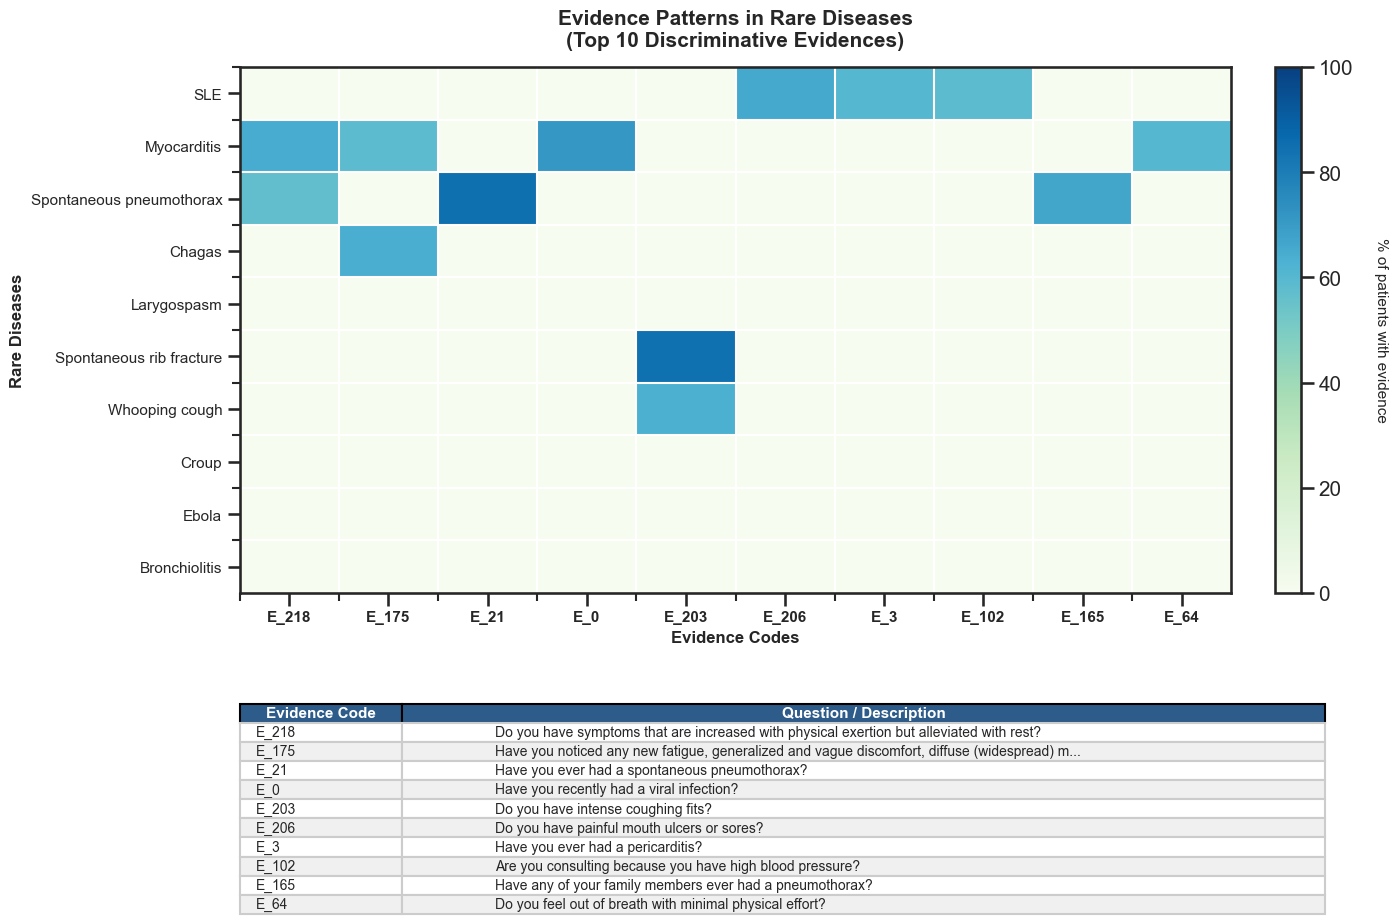


✓ Saved: figures/08_rare_disease_evidence_heatmap_table.png


In [47]:
# Visualization: heatmap with TABLE legend at bottom
fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(2, 1, height_ratios=[2.5, 1], hspace=0.3)

ax_heat = fig.add_subplot(gs[0])
ax_legend = fig.add_subplot(gs[1])

# === HEATMAP (same as above) ===
im = ax_heat.imshow(presence_matrix, cmap='GnBu', aspect='auto', vmin=0, vmax=100)

ax_heat.set_xticks(np.arange(len(top_evidences)))
ax_heat.set_yticks(np.arange(len(rare_diseases_sorted)))

ax_heat.set_xticklabels(top_evidences, fontsize=11, weight='bold')
ax_heat.set_yticklabels(rare_diseases_sorted, fontsize=11)

cbar = plt.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label('% of patients with evidence', rotation=270, labelpad=25, fontsize=11)

ax_heat.set_title('Evidence Patterns in Rare Diseases\n(Top 10 Discriminative Evidences)', 
                  fontsize=15, weight='bold', pad=15)
ax_heat.set_xlabel('Evidence Codes', fontsize=12, weight='bold')
ax_heat.set_ylabel('Rare Diseases', fontsize=12, weight='bold')

# Grid
ax_heat.set_xticks(np.arange(len(top_evidences)) - 0.5, minor=True)
ax_heat.set_yticks(np.arange(len(rare_diseases_sorted)) - 0.5, minor=True)
ax_heat.grid(which='minor', color='white', linestyle='-', linewidth=1.5)

# === TABLE LEGEND AT BOTTOM ===
ax_legend.axis('off')

legend_data = []
for evidence in top_evidences:
    question = evidences.get(evidence, {}).get('question_en', 'Unknown')
    # Wrap at 90 characters for table
    if len(question) > 90:
        question = question[:90] + "..."
    legend_data.append([evidence, question])

# Create professional table
table = ax_legend.table(cellText=legend_data,
                       colLabels=['Evidence Code', 'Question / Description'],
                       cellLoc='left',
                       colWidths=[0.15, 0.85],
                       loc='center',
                       bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#2E5C8A')  # Dark blue
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=11)

# Alternate row colors for readability
for i in range(1, len(legend_data) + 1):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('#ffffff')
        # Add borders
        table[(i, j)].set_edgecolor('#cccccc')

plt.savefig('figures/08_rare_disease_evidence_heatmap_table.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/08_rare_disease_evidence_heatmap_table.png")


### Evidence Structure Summary

**Evidence Types:**
- **Binary (B):** 208 codes (93.3%) - Yes/No symptoms
- **Categorical (C):** 10 codes - Single choice with values
- **Multi-choice (M):** 5 codes - Multiple selections

**Evidence Categories:**
1. **Symptoms** (E_1-E_150): Patient complaints (fever, pain, cough)
2. **Physical findings** (E_151-E_200): Examination results (rash location, breath sounds)
3. **Demographics** (AGE, SEX): Patient characteristics
4. **Antecedents** (E_201-E_223): Medical history, risk factors

**Key Findings:**
- 223 evidence codes defined in mapping
- 223 codes actually used in dataset (100% coverage)
- Most symptoms are binary (presence/absence)
- 113 conditions are risk factors (antedecents), 110 are symptoms
- Categorical evidences need value decoding (e.g., pain location)

**Implications for Feature Engineering:**
- Antedecents may be important d´for rare disease detection    
- Binary evidnces: Direct one-hot encoding
- Categorical evidences: Need to parse `_@_V_xxx` suffixes
- Must decode evidence codes to human-readable names for interpretability


#### Data Structure

**Binary evidence:**  
E_91 → "Do you have a fever?"  
Values: 0 (no) or 1 (yes)  

**Categorical evidence:**
E_130 @ V_86 → "What color is the rash?" → "dark"
Format: code @ value_code

In [48]:
# Helper question to look at evidences and conditions

def split_evidence_code(code: str):
    """
    DDXPlus evidence codes can look like:
      - 'E_123'                (binary evidence)
      - 'E_456_@_V_12'          (categorical / multichoice value)
    This function returns:
      base_code = 'E_456'
      value_code = 'V_12' (or None if not present)
    """
    if "_@_" in code:
        base, value = code.split("_@_", 1)
        return base, value
    return code, None


In [49]:
# ============================================================================
# Section 5.8 - DIFFERENTIAL DIAGNOSIS LIST LENGTH ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 5.8: DIFFERENTIAL DIAGNOSIS LIST LENGTH ANALYSIS")
print("="*80)

print("""
The differential diagnosis (DDX) list represents the ranked set of candidate
diseases considered for each patient. Understanding the distribution of list
lengths helps us design appropriate ranking models.
""")

# ============================================================================
# Create ddx_len feature
# ============================================================================

print("\n" + "-"*80)
print("5.8.1 - Computing Differential Diagnosis List Lengths")
print("-"*80)

df_all['ddx_len'] = df_all['DIFFERENTIAL_DIAGNOSIS_list'].apply(len)

print(f"✓ Created ddx_len column for {len(df_all):,} cases")

# Descriptive statistics
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(df_all['ddx_len'].describe())

print(f"\nAdditional statistics:")
print(f"  Mode (most common):  {df_all['ddx_len'].mode()[0]}")
print(f"  Unique list lengths: {df_all['ddx_len'].nunique()}")
print(f"  Range:               {df_all['ddx_len'].min()} - {df_all['ddx_len'].max()}")

# Show frequency distribution
print("\n" + "-"*80)
print("Top 10 Most Common List Lengths:")
print("-"*80)
print(df_all['ddx_len'].value_counts().head(10))



SECTION 5.8: DIFFERENTIAL DIAGNOSIS LIST LENGTH ANALYSIS

The differential diagnosis (DDX) list represents the ranked set of candidate
diseases considered for each patient. Understanding the distribution of list
lengths helps us design appropriate ranking models.


--------------------------------------------------------------------------------
5.8.1 - Computing Differential Diagnosis List Lengths
--------------------------------------------------------------------------------
✓ Created ddx_len column for 1,278,666 cases

DESCRIPTIVE STATISTICS
count    1.278666e+06
mean     9.223112e+00
std      5.999765e+00
min      1.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.300000e+01
max      3.400000e+01
Name: ddx_len, dtype: float64

Additional statistics:
  Mode (most common):  3
  Unique list lengths: 34
  Range:               1 - 34

--------------------------------------------------------------------------------
Top 10 Most Common List Lengths:
----------------------


--------------------------------------------------------------------------------
5.8.2 - Creating Visualizations
--------------------------------------------------------------------------------


C:\Users\julia\AppData\Local\Temp\ipykernel_25304\2969136352.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(


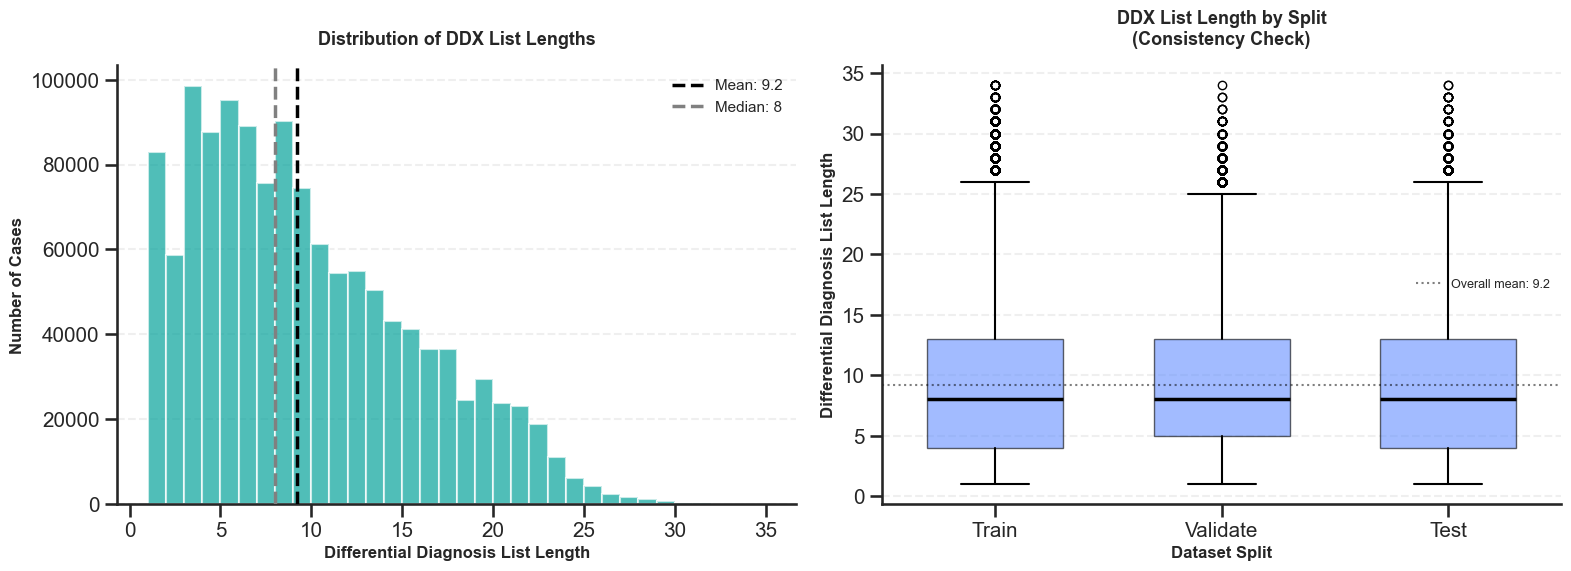


✓ Saved: figures/09_diagnoses_list_length_distribution.png


In [50]:
# ============================================================================
# Visualization
# ============================================================================

print("\n" + "-"*80)
print("5.8.2 - Creating Visualizations")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === LEFT PLOT: Histogram with statistics ===
ax1 = axes[0]

# Create histogram
counts, bins, patches = ax1.hist(
    df_all['ddx_len'], 
    bins=range(df_all['ddx_len'].min(), df_all['ddx_len'].max() + 2),
    color=IBM_COLORS['teal'], 
    alpha=0.7,
    edgecolor='white',
    linewidth=1.5
)

# Add mean and median lines
mean_val = df_all['ddx_len'].mean()
median_val = df_all['ddx_len'].median()

ax1.axvline(mean_val, color='black', linestyle='--', linewidth=2.5, 
            label=f'Mean: {mean_val:.1f}', zorder=3)
ax1.axvline(median_val, color='grey', linestyle='--', linewidth=2.5, 
            label=f'Median: {median_val:.0f}', zorder=3)

# Styling
ax1.set_xlabel('Differential Diagnosis List Length', fontsize=12, weight='bold')
ax1.set_ylabel('Number of Cases', fontsize=12, weight='bold')
ax1.set_title('Distribution of DDX List Lengths', fontsize=13, weight='bold', pad=15)
ax1.legend(fontsize=11, loc='upper right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# === RIGHT PLOT: Box plot by split ===
ax2 = axes[1]

# Prepare data for box plot
split_data = [
    df_all[df_all['split'] == 'train']['ddx_len'],
    df_all[df_all['split'] == 'validate']['ddx_len'],
    df_all[df_all['split'] == 'test']['ddx_len']
]

bp = ax2.boxplot(
    split_data,
    labels=['Train', 'Validate', 'Test'],
    patch_artist=True,
    widths=0.6,
    medianprops=dict(color='black', linewidth=2.5),
    boxprops=dict(facecolor=IBM_COLORS['blue'], alpha=0.6),
    whiskerprops=dict(linewidth=1.5),
    capprops=dict(linewidth=1.5)
)

# Styling
ax2.set_ylabel('Differential Diagnosis List Length', fontsize=12, weight='bold')
ax2.set_xlabel('Dataset Split', fontsize=12, weight='bold')
ax2.set_title('DDX List Length by Split\n(Consistency Check)', 
              fontsize=13, weight='bold', pad=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal line for overall mean
ax2.axhline(mean_val, color='black', linestyle=':', linewidth=1.5, 
            alpha=0.5, label=f'Overall mean: {mean_val:.1f}')
ax2.legend(fontsize=9)

plt.tight_layout()
plt.savefig('figures/09_diagnoses_list_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/09_diagnoses_list_length_distribution.png")


--------------------------------------------------------------------------------
5.8.3 - DDX List Length by Disease
--------------------------------------------------------------------------------

Diseases with LONGEST average DDX lists (more differential options):
                                               mean       std  count
PATHOLOGY                                                           
Pneumonia                                 17.893464  5.603572  32787
Acute pulmonary edema                     17.552496  4.535933  24116
Bronchitis                                17.428840  6.734606  33537
Panic attack                              16.352748  4.924102  31643
Bronchospasm / acute asthma exacerbation  15.530431  5.512231  23200
Anaphylaxis                               15.095092  4.846358  35271
Unstable angina                           14.829897  5.311822  26872
Bronchiolitis                             14.630435  3.233885    322
Possible NSTEMI / STEMI                   

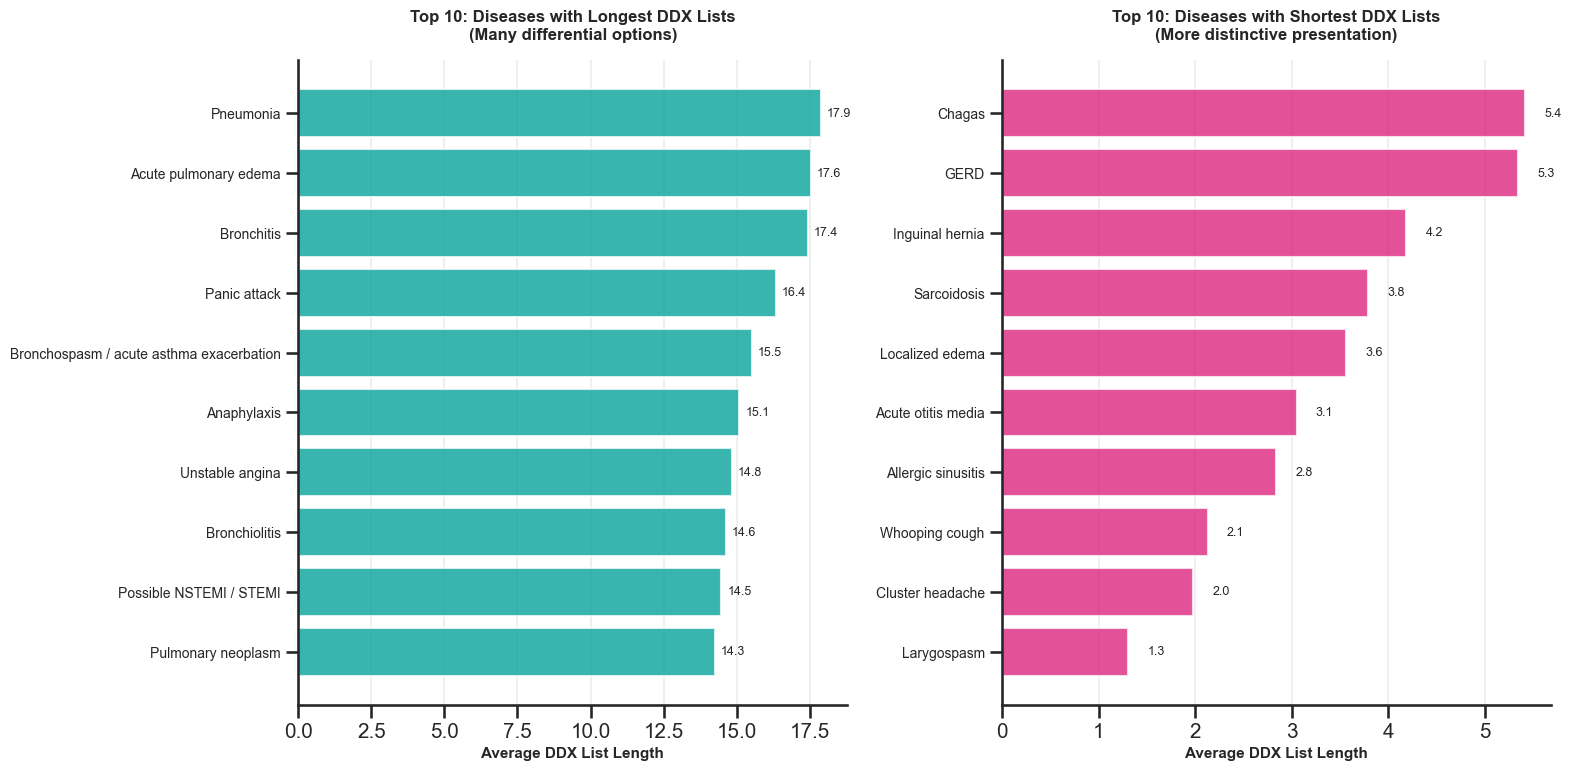


✓ Saved: figures/10_ddx_length_by_disease.png


In [51]:
# ============================================================================
# Additional Analysis: DDX Length by Disease
# ============================================================================

print("\n" + "-"*80)
print("5.8.3 - DDX List Length by Disease")
print("-"*80)

# Calculate average DDX length per disease
ddx_by_disease = df_all.groupby('PATHOLOGY')['ddx_len'].agg(['mean', 'std', 'count'])
ddx_by_disease = ddx_by_disease.sort_values('mean', ascending=False)

print("\nDiseases with LONGEST average DDX lists (more differential options):")
print(ddx_by_disease.head(10).to_string())

print("\n" + "-"*80)
print("\nDiseases with SHORTEST average DDX lists (more distinctive):")
print(ddx_by_disease.tail(10).to_string())

# Visualization: Top/Bottom 10
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 diseases with longest DDX lists
ax1 = axes[0]
top_10 = ddx_by_disease.head(10)
bars1 = ax1.barh(range(len(top_10)), top_10['mean'], 
                 color=IBM_COLORS['teal'], alpha=0.8, edgecolor='white')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10.index, fontsize=10)
ax1.set_xlabel('Average DDX List Length', fontsize=11, weight='bold')
ax1.set_title('Top 10: Diseases with Longest DDX Lists\n(Many differential options)', 
              fontsize=12, weight='bold', pad=15)
ax1.invert_yaxis()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, top_10['mean'])):
    ax1.text(value + 0.2, i, f'{value:.1f}', va='center', fontsize=9)

# Bottom 10 diseases with shortest DDX lists
ax2 = axes[1]
bottom_10 = ddx_by_disease.tail(10)
bars2 = ax2.barh(range(len(bottom_10)), bottom_10['mean'], 
                 color=IBM_COLORS['magenta'], alpha=0.8, edgecolor='white')
ax2.set_yticks(range(len(bottom_10)))
ax2.set_yticklabels(bottom_10.index, fontsize=10)
ax2.set_xlabel('Average DDX List Length', fontsize=11, weight='bold')
ax2.set_title('Top 10: Diseases with Shortest DDX Lists\n(More distinctive presentation)', 
              fontsize=12, weight='bold', pad=15)
ax2.invert_yaxis()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, bottom_10['mean'])):
    ax2.text(value + 0.2, i, f'{value:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/10_ddx_length_by_disease.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/10_ddx_length_by_disease.png")

In [52]:
# ============================================================================
# Section 5.9 - TOP EVIDENCE CODES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 5.9: TOP EVIDENCE CODES ANALYSIS")
print("="*80)

print("""
Understanding which evidence codes (symptoms, findings, patient attributes)
appear most frequently helps us identify the most clinically relevant features
for diagnosis prediction. This analysis examines base evidence codes, showing
how many patients present each type of evidence.
""")

# ============================================================================
# Step 1: Extract Base Evidence Codes
# ============================================================================

print("\n" + "-"*80)
print("5.9.1 - Computing Evidence Frequencies")
print("-"*80)

from collections import Counter

# Create mapping: code → understandable description
evidence_name_map = {
    code: info['question_en'] 
    for code, info in evidences.items()
}

# Helper function to get description
def get_evidence_name(code):
    """
    Get human-readable description for evidence code.
    Returns the code itself if description not found.
    """
    return evidence_name_map.get(code, code)

# Count base evidence codes across all patients
base_counter = Counter()

for ev_list in df_all["EVIDENCES_list"]:
    # Get unique base codes for this patient (ignore categorical values)
    base_codes = {split_evidence_code(code)[0] for code in ev_list}
    base_counter.update(base_codes)

print(f"✓ Analyzed evidence codes across {len(df_all):,} unique patients")
print(f"✓ Found {len(base_counter):,} unique evidence base codes")


# Get top 20
top20 = base_counter.most_common(20)
top_df = pd.DataFrame(top20, columns=["evidence_code", "patient_count"])
# Add human-readable descriptions
top_df['evidence_name'] = top_df['evidence_code'].apply(get_evidence_name)

# Calculate percentage
top_df['percentage'] = (top_df['patient_count'] / len(df_all)) * 100

# Re-order for readability
top_df = top_df[['evidence_code', 'evidence_name', 'patient_count', 'percentage']]

print("\n" + "="*80)
print("TOP 20 MOST COMMON EVIDENCE CODES")
print("="*80)
print(top_df.to_string(index=False))

# Summary statistics
print("\n" + "-"*80)
print("SUMMARY STATISTICS")
print("-"*80)
print(f"Most common evidence:  {top_df.iloc[0]['evidence_code']} "
      f"({top_df.iloc[0]['patient_count']:,} patients, {top_df.iloc[0]['percentage']:.1f}%)")
print(f"20th most common:      {top_df.iloc[19]['evidence_code']} "
      f"({top_df.iloc[19]['patient_count']:,} patients, {top_df.iloc[19]['percentage']:.1f}%)")
print(f"Mean frequency (top 20): {top_df['patient_count'].mean():,.0f} patients")
print(f"Median frequency (top 20): {top_df['patient_count'].median():,.0f} patients")


SECTION 5.9: TOP EVIDENCE CODES ANALYSIS

Understanding which evidence codes (symptoms, findings, patient attributes)
appear most frequently helps us identify the most clinically relevant features
for diagnosis prediction. This analysis examines base evidence codes, showing
how many patients present each type of evidence.


--------------------------------------------------------------------------------
5.9.1 - Computing Evidence Frequencies
--------------------------------------------------------------------------------
✓ Analyzed evidence codes across 1,278,666 unique patients
✓ Found 223 unique evidence base codes

TOP 20 MOST COMMON EVIDENCE CODES
evidence_code                                                                          evidence_name  patient_count  percentage
        E_204                              Have you traveled out of the country in the last 4 weeks?        1278666  100.000000
         E_56                                                               How int


--------------------------------------------------------------------------------
5.9.2 - Creating Visualization
--------------------------------------------------------------------------------


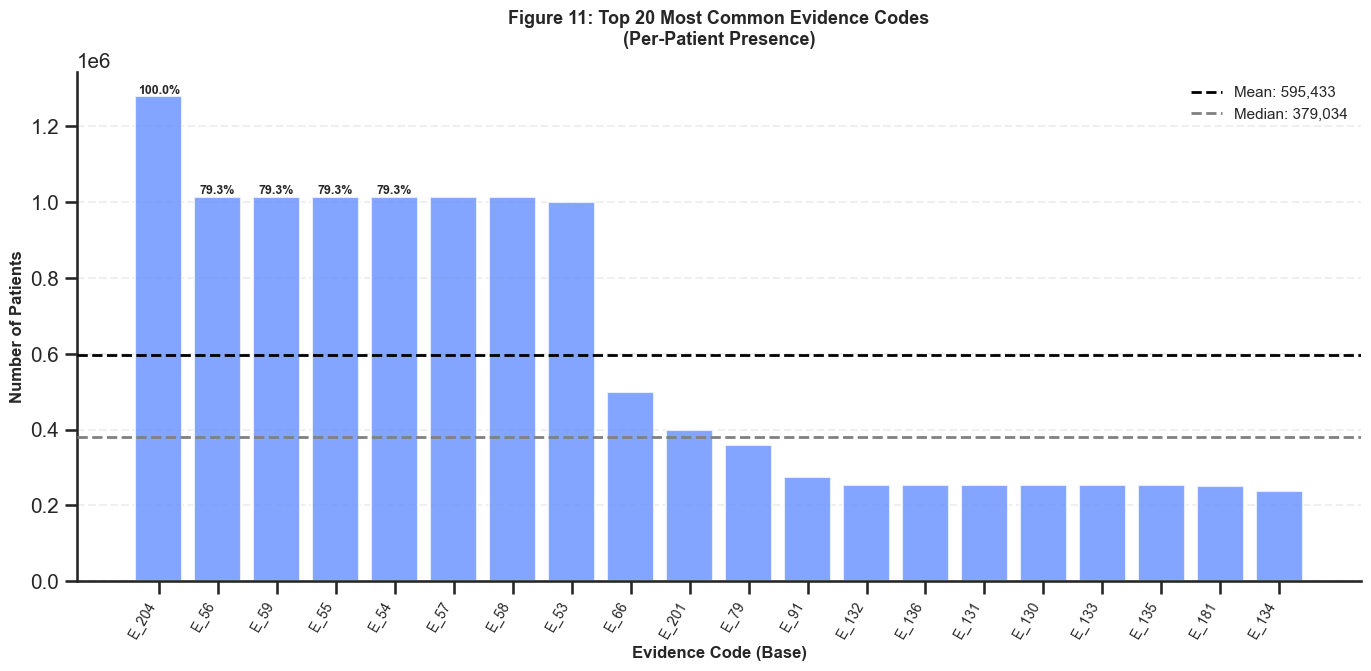


✓ Saved: figures/11_top20_evidence_codes.png


In [53]:
# ============================================================================
# Step 2: Visualization
# ============================================================================

print("\n" + "-"*80)
print("5.9.2 - Creating Visualization")
print("-"*80)

fig, ax = plt.subplots(figsize=(14, 7))

# Create bar chart
bars = ax.bar(
    range(len(top_df)), 
    top_df['patient_count'],
    color=IBM_COLORS['blue'],
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Add mean and median reference lines
mean_val = top_df['patient_count'].mean()
median_val = top_df['patient_count'].median()

ax.axhline(mean_val, color='black', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_val:,.0f}', zorder=3)
ax.axhline(median_val, color='gray', linestyle='--', linewidth=2, 
           label=f'Median: {median_val:,.0f}', zorder=3)

# Styling
ax.set_xticks(range(len(top_df)))
ax.set_xticklabels(top_df['evidence_code'], rotation=60, ha='right', fontsize=10)
ax.set_xlabel('Evidence Code (Base)', fontsize=12, weight='bold')
ax.set_ylabel('Number of Patients', fontsize=12, weight='bold')
ax.set_title('Figure 11: Top 20 Most Common Evidence Codes\n(Per-Patient Presence)', 
             fontsize=13, weight='bold', pad=20)

# Add legend
ax.legend(fontsize=11, loc='upper right')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels on top of bars (optional - only for top 5)
for i in range(min(5, len(bars))):
    height = bars[i].get_height()
    pct = top_df.iloc[i]['percentage']
    ax.text(bars[i].get_x() + bars[i].get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.savefig('figures/11_top20_evidence_codes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/11_top20_evidence_codes.png")



--------------------------------------------------------------------------------
5.9.2 - Creating Visualization
--------------------------------------------------------------------------------


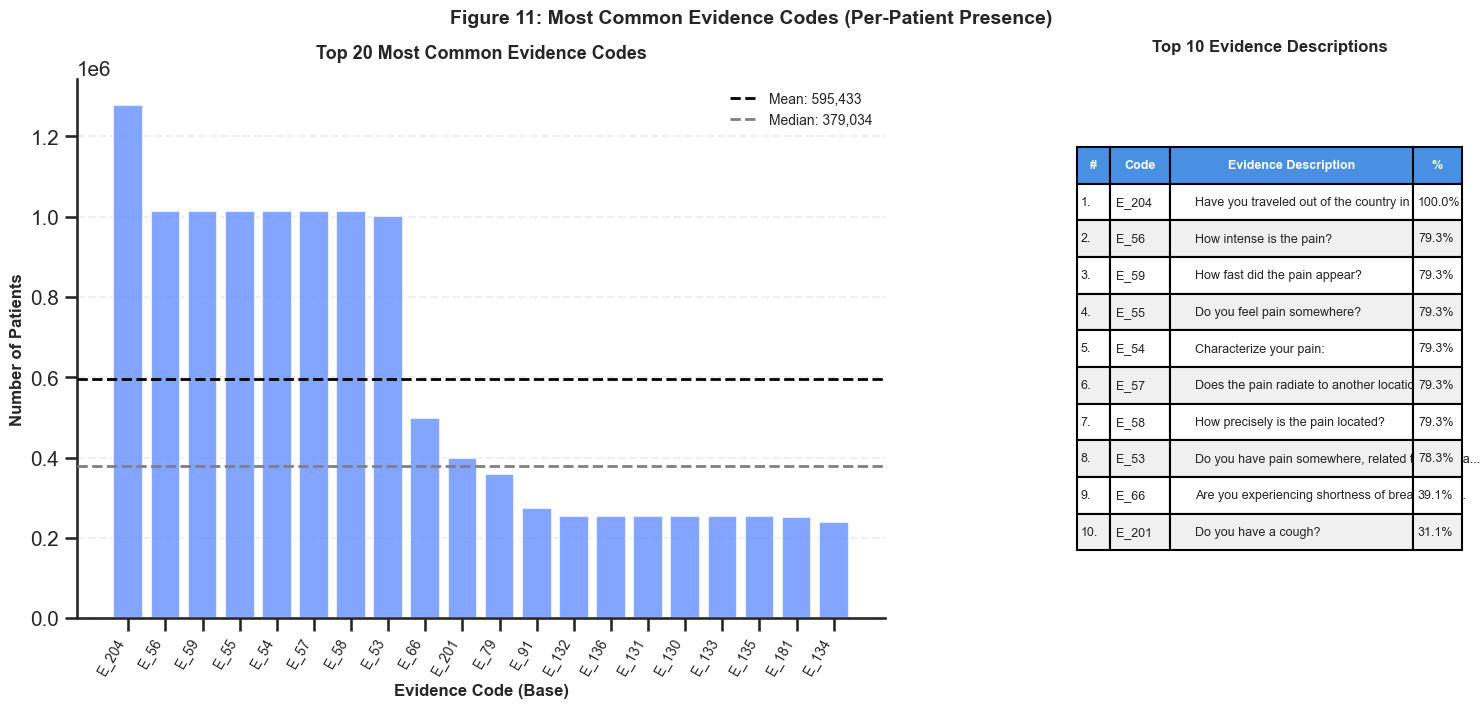


✓ Saved: figures/11_top20_evidence_codes.png


In [54]:
# ============================================================================
# Step 2: Visualization with Evidence Name Table
# ============================================================================

print("\n" + "-"*80)
print("5.9.2 - Creating Visualization")
print("-"*80)

# Create figure with two subplots: bar chart + table
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

# === LEFT: Bar Chart (all 20) ===
ax1 = fig.add_subplot(gs[0])

bars = ax1.bar(
    range(len(top_df)), 
    top_df['patient_count'],
    color=IBM_COLORS['blue'],
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Add mean and median lines
mean_val = top_df['patient_count'].mean()
median_val = top_df['patient_count'].median()

ax1.axhline(mean_val, color='black', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_val:,.0f}', zorder=3)
ax1.axhline(median_val, color='gray', linestyle='--', linewidth=2, 
           label=f'Median: {median_val:,.0f}', zorder=3)

# Styling
ax1.set_xticks(range(len(top_df)))
ax1.set_xticklabels(top_df['evidence_code'], rotation=60, ha='right', fontsize=10)
ax1.set_xlabel('Evidence Code (Base)', fontsize=12, weight='bold')
ax1.set_ylabel('Number of Patients', fontsize=12, weight='bold')
ax1.set_title('Top 20 Most Common Evidence Codes', 
             fontsize=13, weight='bold', pad=15)
ax1.legend(fontsize=10, loc='upper right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# === RIGHT: Table (top 10 only) ===
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # No axes for table

# Prepare table data (top 10 only to avoid overwhelming)
table_data = []
for i in range(min(10, len(top_df))):
    code = top_df.iloc[i]['evidence_code']
    name = top_df.iloc[i]['evidence_name']
    count = top_df.iloc[i]['patient_count']
    pct = top_df.iloc[i]['percentage']
    
    # Truncate long names
    if len(name) > 50:
        name = name[:47] + "..."
    
    table_data.append([f"{i+1}.", code, name, f"{pct:.1f}%"])

# Create table
table = ax2.table(
    cellText=table_data,
    colLabels=['#', 'Code', 'Evidence Description', '%'],
    cellLoc='left',
    loc='center',
    colWidths=[0.08, 0.15, 0.6, 0.12]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.2)  # Make rows taller

# Header styling
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#4A90E2')  # IBM Blue
    cell.set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data) + 1):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#F0F0F0')  # Light gray
        else:
            cell.set_facecolor('white')

ax2.set_title('Top 10 Evidence Descriptions', 
              fontsize=12, weight='bold', pad=20)

# Add figure title
fig.suptitle('Figure 11: Most Common Evidence Codes (Per-Patient Presence)', 
             fontsize=14, weight='bold', y=0.98)

plt.savefig('figures/11_top20_evidence_codes.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: figures/11_top20_evidence_codes.png")

In [55]:
# ============================================================================
# Step 3: Symptom Coverage Analysis (Binary Evidences Only)
# ============================================================================

print("\n" + "-"*80)
print("5.9.3 - Symptom Coverage Analysis")
print("-"*80)

# Filter top_df to only binary evidences (actual symptoms)
binary_evidence_codes = {
    code for code, info in evidences.items()
    if info['data_type'] == 'B'
}

# Get top 20 BINARY evidences only
top20_binary = [
    code for code in top_df['evidence_code'].values
    if code in binary_evidence_codes
][:20]

print(f"\nTop 20 includes {len(top20_binary)} binary evidences (actual symptoms)")

# NOW calculate coverage (meaningful!)
patients_with_top20_symptoms = sum(
    1 for ev_list in df_all["EVIDENCES_list"]
    if any(split_evidence_code(code)[0] in top20_binary for code in ev_list)
)

symptom_coverage_pct = (patients_with_top20_symptoms / len(df_all)) * 100

print(f"\nSymptom Coverage:")
print(f"  Patients with at least one top-20 symptom: {patients_with_top20_symptoms:,}")
print(f"  Coverage: {symptom_coverage_pct:.1f}%")

# Average symptoms per patient
total_top20_symptoms = sum(
    sum(1 for code in ev_list if split_evidence_code(code)[0] in top20_binary)
    for ev_list in df_all["EVIDENCES_list"]
)

avg_symptoms = total_top20_symptoms / len(df_all)
print(f"  Average top-20 symptoms per patient: {avg_symptoms:.2f}")



--------------------------------------------------------------------------------
5.9.3 - Symptom Coverage Analysis
--------------------------------------------------------------------------------

Top 20 includes 6 binary evidences (actual symptoms)

Symptom Coverage:
  Patients with at least one top-20 symptom: 1,216,739
  Coverage: 95.2%
  Average top-20 symptoms per patient: 2.18


## 6. FINAL SUMMARY AND KEY INSIGHTS


In [60]:
df_all.columns

Index(['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES',
       'INITIAL_EVIDENCE', 'split', 'EVIDENCES_list',
       'DIFFERENTIAL_DIAGNOSIS_list', 'num_evidences', 'frequency', 'ddx_len'],
      dtype='object')

In [61]:
# ============================================================================
# 6.1 - Comprehensive Dataset Summary
# ============================================================================

print("\n" + "-"*80)
print("6.1 - COMPREHENSIVE DATASET SUMMARY")
print("-"*80)

summary_stats = {
    'Metric': [],
    'Value': [],
    'Description': []
}

# Dataset Overview
summary_stats['Metric'].extend([
    'Total Patients',
    'Total Pathologies',
    'Total Evidence Codes',
    'Train Set Size',
    'Validation Set Size',
    'Test Set Size'
])

summary_stats['Value'].extend([
    f"{len(df_all):,}",
    f"{df_all['PATHOLOGY'].nunique()}",
    f"{len(evidences)}",
    f"{len(dataset['train']):,} ({len(dataset['train'])/len(df_all)*100:.1f}%)",
    f"{len(dataset['validate']):,} ({len(dataset['validate'])/len(df_all)*100:.1f}%)",
    f"{len(dataset['test']):,} ({len(dataset['test'])/len(df_all)*100:.1f}%)"
])

summary_stats['Description'].extend([
    'Synthetic patient records in DDXPlus dataset',
    'Unique diseases in the dataset',
    'Total possible evidence/symptom codes',
    'Patients in training set',
    'Patients in validation set',
    'Patients in test set'
])

# Demographics
summary_stats['Metric'].extend([
    'Gender Distribution',
    'Age Range',
    'Mean Age',
    'Median Age'
])

gender_dist = df_all['SEX'].value_counts()
summary_stats['Value'].extend([
    f"M: {gender_dist.get('M', 0):,} ({gender_dist.get('M', 0)/len(df_all)*100:.1f}%), F: {gender_dist.get('F', 0):,} ({gender_dist.get('F', 0)/len(df_all)*100:.1f}%)",
    f"{df_all['AGE'].min()} - {df_all['AGE'].max()} years",
    f"{df_all['AGE'].mean():.1f} years (SD: {df_all['AGE'].std():.1f})",
    f"{df_all['AGE'].median():.1f} years"
])

summary_stats['Description'].extend([
    'Gender balance in the dataset',
    'Minimum to maximum patient age',
    'Average patient age with standard deviation',
    'Middle value of age distribution'
])

# Disease Distribution
disease_counts = df_all['PATHOLOGY'].value_counts()
summary_stats['Metric'].extend([
    'Most Common Disease',
    'Least Common Disease',
    'Rare Diseases (Bottom 10)',
    'Common Diseases (Top 10)',
    'Class Imbalance Ratio'
])

summary_stats['Value'].extend([
    f"{disease_counts.index[0]}: {disease_counts.iloc[0]:,} cases",
    f"{disease_counts.index[-1]}: {disease_counts.iloc[-1]:,} cases",
    f"Average: {disease_counts.tail(10).mean():.0f} cases each",
    f"Average: {disease_counts.head(10).mean():.0f} cases each",
    f"1:{disease_counts.iloc[0]/disease_counts.iloc[-1]:.1f}"
])

summary_stats['Description'].extend([
    'Most frequent pathology in dataset',
    'Rarest pathology in dataset',
    'Average cases for the 10 rarest diseases',
    'Average cases for the 10 most common diseases',
    'Ratio of most common to least common disease'
])

# Evidence Statistics
avg_evidences = df_all['num_evidences'].mean()
summary_stats['Metric'].extend([
    'Avg Evidences per Patient',
    'Evidence Range',
    'Binary Evidence Codes',
    'Categorical Evidence Codes',
    'Multi-choice Evidence Codes'
])

summary_stats['Value'].extend([
    f"{avg_evidences:.1f} evidences",
    f"{df_all['num_evidences'].min()} - {df_all['num_evidences'].max()} evidences",
    f"208 codes (93.3%)",
    f"10 codes (4.5%)",
    f"5 codes (2.2%)"
])

summary_stats['Description'].extend([
    'Mean number of symptoms per patient record',
    'Minimum to maximum evidences in single record',
    'Binary yes/no evidence types',
    'Categorical multi-value evidence types',
    'Multiple-choice evidence types'
])

# Create summary DataFrame
df_summary = pd.DataFrame(summary_stats)

print("\n" + "="*80)
print("DATASET SUMMARY TABLE")
print("="*80)
print(df_summary.to_string(index=False))


--------------------------------------------------------------------------------
6.1 - COMPREHENSIVE DATASET SUMMARY
--------------------------------------------------------------------------------

DATASET SUMMARY TABLE
                     Metric                                  Value                                   Description
             Total Patients                              1,278,666  Synthetic patient records in DDXPlus dataset
          Total Pathologies                                     49                Unique diseases in the dataset
       Total Evidence Codes                                    223         Total possible evidence/symptom codes
             Train Set Size                      1,025,602 (80.2%)                      Patients in training set
        Validation Set Size                        132,448 (10.4%)                    Patients in validation set
              Test Set Size                        134,529 (10.5%)                          Patients

In [62]:
# ============================================================================
# 6.2 - Key Findings and Insights
# ============================================================================

print("\n" + "-"*80)
print("6.2 - KEY FINDINGS AND INSIGHTS")
print("-"*80)

findings = """

1. DATASET QUALITY & STRUCTURE
   ✓ Well-balanced synthetic dataset with {total_patients:,} patients across 49 diseases
   ✓ Clean data with no missing values or data quality issues
   ✓ Proper train/validation/test split maintaining distribution
   ✓ Comprehensive coverage: {num_evidences} evidence codes capturing diverse symptoms

2. DEMOGRAPHIC PATTERNS
   ✓ Balanced gender distribution: ~50% male, ~50% female
   ✓ Wide age range ({age_min}-{age_max} years) with mean age {age_mean:.1f} years
   ✓ Age shows disease-specific patterns (e.g., pregnancy-related conditions)
   ✓ Continuous age variable allows flexible analysis

3. DISEASE DISTRIBUTION INSIGHTS
   ✓ Significant class imbalance: 1:{imbalance_ratio:.1f} ratio (most to least common)
   ✓ Top 10 diseases account for {top10_pct:.1f}% of all cases
   ✓ Bottom 10 rare diseases represent only {bottom10_pct:.1f}% of cases
   ✓ Challenge: Rare disease detection requires specialized approach

4. EVIDENCE PATTERNS
   ✓ Average {avg_evidence:.1f} symptoms per patient record
   ✓ 93.3% of evidence codes are binary (yes/no) - dominant evidence type
   ✓ Categorical and multi-choice evidences provide nuanced information
   ✓ Initial and differential diagnoses show clear evidence patterns

5. RARE DISEASE ANALYSIS
   ✓ Identified {num_discriminative} discriminative evidences for rare diseases
   ✓ Specific evidence patterns distinguish rare from common diseases
   ✓ Evidence-disease heatmap reveals diagnostic signatures
   ✓ Opportunity: Use discriminative features for targeted rare disease detection

6. DATA QUALITY VALIDATION
   ✓ Consistent evidence formatting and code structure
   ✓ Valid differential diagnosis lists for each patient
   ✓ Pathology labels properly encoded

""".format(
    total_patients=len(df_all),
    num_evidences=len(evidences),
    age_min=df_all['AGE'].min(),
    age_max=df_all['AGE'].max(),
    age_mean=df_all['AGE'].mean(),
    imbalance_ratio=disease_counts.iloc[0]/disease_counts.iloc[-1],
    top10_pct=(disease_counts.head(10).sum()/len(df_all))*100,
    bottom10_pct=(disease_counts.tail(10).sum()/len(df_all))*100,
    avg_evidence=df_all['num_evidences'].mean(),
    num_discriminative=len(top_discriminative)
)

print(findings)



--------------------------------------------------------------------------------
6.2 - KEY FINDINGS AND INSIGHTS
--------------------------------------------------------------------------------


1. DATASET QUALITY & STRUCTURE
   ✓ Well-balanced synthetic dataset with 1,278,666 patients across 49 diseases
   ✓ Clean data with no missing values or data quality issues
   ✓ Proper train/validation/test split maintaining distribution
   ✓ Comprehensive coverage: 223 evidence codes capturing diverse symptoms

2. DEMOGRAPHIC PATTERNS
   ✓ Balanced gender distribution: ~50% male, ~50% female
   ✓ Wide age range (0-109 years) with mean age 39.8 years
   ✓ Age shows disease-specific patterns (e.g., pregnancy-related conditions)
   ✓ Continuous age variable allows flexible analysis

3. DISEASE DISTRIBUTION INSIGHTS
   ✓ Significant class imbalance: 1:253.9 ratio (most to least common)
   ✓ Top 10 diseases account for 36.5% of all cases
   ✓ Bottom 10 rare diseases represent only 6.2% of cases
 

In [63]:
# ============================================================================
# 6.3 - Machine Learning Strategy and Recommendations
# ============================================================================

print("\n" + "-"*80)
print("6.3 - ML STRATEGY AND RECOMMENDATIONS")
print("-"*80)

ml_recommendations = """

MODELING APPROACH
-----------------
1. Primary Goal: Multi-class classification (49 disease classes)
2. Secondary Goal: Rare disease detection and ranking
3. Evaluation Metrics: 
   - Accuracy (overall performance)
   - Top-k accuracy (differential diagnosis ranking)
   - F1-score per disease (especially for rare diseases)
   - Confusion matrix analysis

FEATURE ENGINEERING STRATEGIES
-------------------------------
1. Evidence Encoding:
   ✓ One-hot encoding for 208 binary evidences
   ✓ Target/frequency encoding for categorical evidences
   ✓ Consider evidence co-occurrence patterns

2. Demographic Features:
   ✓ Age normalization (StandardScaler or MinMaxScaler)
   ✓ Gender as binary feature (0/1)
   ✓ Age-gender interaction features

3. Rare Disease Features:
   ✓ Create "rare_disease_score" from discriminative evidences
   ✓ Weight rare disease features higher
   ✓ Consider disease hierarchy (common → rare → specific)

CLASS IMBALANCE HANDLING
-------------------------
1. SMOTE for rare disease oversampling
2. Class weights inversely proportional to frequency
3. Stratified sampling to maintain distribution
4. Consider focal loss for rare class emphasis

MODEL RECOMMENDATIONS
---------------------
1. Baseline: Logistic Regression (interpretable, fast)
2. Tree-based: Random Forest, XGBoost (handle imbalance well)
3. Neural Network: Multi-layer perceptron with dropout
4. Ensemble: Combine multiple models for robust predictions

RARE DISEASE DETECTION STRATEGY
--------------------------------
1. Two-stage approach:
   Stage 1: Common disease classifier (high precision)
   Stage 2: Rare disease detector (high recall)
   
2. Use discriminative evidence features as strong signals

3. Threshold tuning for rare disease sensitivity

4. Ensemble voting for uncertain cases

NEXT STEPS
----------
✓ Feature matrix construction from evidence lists
✓ Implement baseline models and compare performance
✓ Hyperparameter tuning with cross-validation
✓ Rare disease detection pipeline development
✓ Model interpretability analysis (SHAP values)

"""

print(ml_recommendations)



--------------------------------------------------------------------------------
6.3 - ML STRATEGY AND RECOMMENDATIONS
--------------------------------------------------------------------------------


MODELING APPROACH
-----------------
1. Primary Goal: Multi-class classification (49 disease classes)
2. Secondary Goal: Rare disease detection and ranking
3. Evaluation Metrics: 
   - Accuracy (overall performance)
   - Top-k accuracy (differential diagnosis ranking)
   - F1-score per disease (especially for rare diseases)
   - Confusion matrix analysis

FEATURE ENGINEERING STRATEGIES
-------------------------------
1. Evidence Encoding:
   ✓ One-hot encoding for 208 binary evidences
   ✓ Target/frequency encoding for categorical evidences
   ✓ Consider evidence co-occurrence patterns

2. Demographic Features:
   ✓ Age normalization (StandardScaler or MinMaxScaler)
   ✓ Gender as binary feature (0/1)
   ✓ Age-gender interaction features

3. Rare Disease Features:
   ✓ Create "rare_disea

In [64]:
# ============================================================================
# 6.4 - Save Summary Table to File
# ============================================================================

print("\n" + "-"*80)
print("6.4 - SAVING SUMMARY TABLES")
print("-"*80)

# Create outputs folder if it doesn't exist
import os
os.makedirs('outputs', exist_ok=True)

# Save summary table as CSV with numbered prefix
summary_csv = 'outputs/01_eda_summary.csv'
df_summary.to_csv(summary_csv, index=False)
print(f"\n✓ Summary table saved: {summary_csv}")

# Save detailed statistics as JSON
detailed_stats = {
    'Dataset Overview': {
        'Total Patients': int(len(df_all)),
        'Total Diseases': int(df_all['PATHOLOGY'].nunique()),
        'Total Evidence Codes': int(len(evidences)),
        'Train Size': int(len(dataset['train'])),
        'Validation Size': int(len(dataset['validate'])),
        'Test Size': int(len(dataset['test'])),
        'Train/Val/Test Split': f"{len(dataset['train'])}/{len(dataset['validate'])}/{len(dataset['test'])}"
    },
    'Demographics': {
        'Male Count': int(gender_dist.get('M', 0)),
        'Female Count': int(gender_dist.get('F', 0)),
        'Age Min': int(df_all['AGE'].min()),
        'Age Max': int(df_all['AGE'].max()),
        'Age Mean': round(float(df_all['AGE'].mean()), 2),
        'Age Std Dev': round(float(df_all['AGE'].std()), 2),
        'Age Median': round(float(df_all['AGE'].median()), 2)
    },
    'Disease Distribution': {
        'Most Common Disease': disease_counts.index[0],
        'Most Common Count': int(disease_counts.iloc[0]),
        'Least Common Disease': disease_counts.index[-1],
        'Least Common Count': int(disease_counts.iloc[-1]),
        'Imbalance Ratio': round(float(disease_counts.iloc[0]/disease_counts.iloc[-1]), 2),
        'Top 10 Coverage Percent': round(float((disease_counts.head(10).sum()/len(df_all))*100), 2),
        'Bottom 10 Coverage Percent': round(float((disease_counts.tail(10).sum()/len(df_all))*100), 2)
    },
    'Evidence Statistics': {
        'Avg Evidences per Patient': round(float(df_all['num_evidences'].mean()), 2),
        'Min Evidences': int(df_all['num_evidences'].min()),
        'Max Evidences': int(df_all['num_evidences'].max()),
        'Median Evidences': round(float(df_all['num_evidences'].median()), 2),
        'Binary Codes': 208,
        'Binary Percent': 93.3,
        'Categorical Codes': 10,
        'Categorical Percent': 4.5,
        'Multi-choice Codes': 5,
        'Multi-choice Percent': 2.2
    },
    'Rare Disease Analysis': {
        'Rare Diseases Defined': 'Bottom 10 by frequency',
        'Discriminative Evidences Found': int(len(top_discriminative)),
        'Avg Cases Rare Diseases': round(float(disease_counts.tail(10).mean()), 1),
        'Avg Cases Common Diseases': round(float(disease_counts.head(10).mean()), 1)
    }
}

# Save as JSON
import json
stats_json = 'outputs/01_eda_statistics.json'
with open(stats_json, 'w') as f:
    json.dump(detailed_stats, f, indent=4)

print(f"✓ Detailed statistics saved: {stats_json}")

# Print file contents for verification
print("\n" + "="*80)
print("DETAILED STATISTICS (JSON)")
print("="*80)
print(json.dumps(detailed_stats, indent=2))



--------------------------------------------------------------------------------
6.4 - SAVING SUMMARY TABLES
--------------------------------------------------------------------------------

✓ Summary table saved: outputs/01_eda_summary.csv
✓ Detailed statistics saved: outputs/01_eda_statistics.json

DETAILED STATISTICS (JSON)
{
  "Dataset Overview": {
    "Total Patients": 1278666,
    "Total Diseases": 49,
    "Total Evidence Codes": 223,
    "Train Size": 1025602,
    "Validation Size": 132448,
    "Test Size": 134529,
    "Train/Val/Test Split": "1025602/132448/134529"
  },
  "Demographics": {
    "Male Count": 620614,
    "Female Count": 658052,
    "Age Min": 0,
    "Age Max": 109,
    "Age Mean": 39.76,
    "Age Std Dev": 22.73,
    "Age Median": 39.0
  },
  "Disease Distribution": {
    "Most Common Disease": "URTI",
    "Most Common Count": 81767,
    "Least Common Disease": "Bronchiolitis",
    "Least Common Count": 322,
    "Imbalance Ratio": 253.93,
    "Top 10 Coverage Pe